# Temporal GNN Training

- Loads model from `temporal_gnn.py` file
- Starts training from 2014 (skips noisy early years)
- Uses 2K stratified samples for fast iteration
- Lazy loading with LRU cache
- Works both locally and on Colab

## 1. Setup Environment

In [ ]:
# Check if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
    !pip install torch-geometric
    !pip install python-dateutil
else:
    print("Running locally")

Running on Google Colab


In [ ]:
# Check GPU availability
import torch

# Default values
USE_BF16 = False
USE_AMP = torch.cuda.is_available()  # AMP works only on CUDA

if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0).lower()
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9

    print(f"GPU available: {gpu_name}")
    print(f"GPU memory: {gpu_mem:.2f} GB")

    # Precision selection based on GPU family
    if any(key in gpu_name for key in ['b200', 'b100', 'blackwell']):
        print("Detected Blackwell GPU → using BF16 for optimal performance")
        USE_BF16 = True

    elif any(key in gpu_name for key in ['h100', 'a100']):
        print("Detected Hopper/Ampere GPU → using BF16")
        USE_BF16 = True

    else:
        print("Standard CUDA GPU detected → using FP16 (AMP)")
        USE_BF16 = False

else:
    device = torch.device('cpu')
    print("No GPU available → using CPU")
    USE_BF16 = False
    USE_AMP = False

print("\nFinal Precision Settings")
print(f"Using device: {device}")
print(f"AMP enabled:  {USE_AMP}")
print(f"BF16 enabled: {USE_BF16}")

GPU available: nvidia a100-sxm4-40gb
GPU memory: 42.47 GB
Detected Hopper/Ampere GPU → using BF16

Final Precision Settings
Using device: cuda
AMP enabled:  True
BF16 enabled: True


In [ ]:
# Setup paths based on environment
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    PROJECT_DIR = '/content/drive/MyDrive/dont-thread-on-me'
    GRAPH_DIR = f'{PROJECT_DIR}/data/processed/graphs'

    # Add project directory to path for imports
    if PROJECT_DIR not in sys.path:
        sys.path.append(PROJECT_DIR)

    print(f"Google Drive mounted")
    print(f"Project directory: {PROJECT_DIR}")

else:
    PROJECT_DIR = '..'
    GRAPH_DIR = '../data/processed/graphs'

    if PROJECT_DIR not in sys.path:
        sys.path.append(PROJECT_DIR)

    print(f"Running locally")
    print(f"Project directory: {PROJECT_DIR}")

print(f"Graph directory: {GRAPH_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted
Project directory: /content/drive/MyDrive/dont-thread-on-me
Graph directory: /content/drive/MyDrive/dont-thread-on-me/data/processed/graphs


In [ ]:
# Verify data directory exists
from pathlib import Path

graph_dir = Path(GRAPH_DIR)

if not graph_dir.exists():
    print(f"ERROR: Graph directory not found: {graph_dir}")
    print(f"\nPlease upload your processed graphs to:")
    print(f"  {GRAPH_DIR}")
else:
    communities = [d.name for d in graph_dir.iterdir() if d.is_dir()]
    print(f"Found {len(communities)} communities")

    # Show first few
    for comm in sorted(communities)[:5]:
        comm_path = graph_dir / comm
        n_graphs = len(list(comm_path.glob('*.pt')))
        print(f"  - {comm}: {n_graphs} monthly graphs")

    if len(communities) > 5:
        print(f"  ... and {len(communities) - 5} more")

Found 177 communities
  - 3dprinting.stackexchange.com: 98 monthly graphs
  - academia.stackexchange.com: 147 monthly graphs
  - ai.stackexchange.com: 91 monthly graphs
  - android.stackexchange.com: 174 monthly graphs
  - anime.stackexchange.com: 135 monthly graphs
  ... and 172 more


## 2. Import Model from temporal_gnn.py

**Note:** Make sure `temporal_gnn.py` is uploaded to your project directory:
- Colab: `/content/drive/MyDrive/dont-thread-on-me/src/models/temporal_gnn.py`
- Local: `../src/models/temporal_gnn.py`

In [ ]:
# Try to import the model
try:
    from src.models.temporal_gnn import create_model
    print("Successfully imported model from temporal_gnn.py")
except ImportError as e:
    print("Failed to import model")
    print(f"\nError: {e}")
    print(f"\nPlease make sure temporal_gnn.py exists at:")
    if IN_COLAB:
        print(f"  /content/drive/MyDrive/dont-thread-on-me/src/models/temporal_gnn.py")
    else:
        print(f"  ../src/models/temporal_gnn.py")
    raise

Successfully imported model from temporal_gnn.py


## 3. Define Optimized Dataset

- **No pre-caching** - starts training immediately
- **LRU cache** - automatically caches frequently accessed graphs
- **Stratified sampling** - representative samples across communities
- **2014 start date** - skips noisy early Stack Exchange years

In [ ]:
# Dataset imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import List, Dict
from datetime import datetime
from dateutil.relativedelta import relativedelta
from functools import lru_cache
from collections import defaultdict
import random
import numpy as np
from tqdm.auto import tqdm

In [ ]:
class FastTemporalDataset(Dataset):
    """
    Optimized dataset with lazy loading + LRU cache + target normalization.

    - No slow pre-caching step (starts training immediately)
    - LRU cache automatically keeps hot graphs in memory
    - Memory efficient (only caches ~2000 graphs, not all)
    - Stratified sampling for representative coverage
    - Starts from 2014 (skips noisy early years)
    - Target normalization: Standardizes all targets to mean=0, std=1
    """

    def __init__(
        self,
        graph_dir: Path,
        split: str = 'train',
        sequence_length: int = 12,
        prediction_horizon: int = 6,
        max_samples: int = None,
        cache_size: int = 2000,
        stratified_sample: bool = True
    ):
        self.graph_dir = Path(graph_dir)
        self.split = split
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon

        # Temporal splits
        self.split_ranges = {
            'train': ('2014-01', '2020-06'),  # Predict through 2020-12
            'val':   ('2020-07', '2022-09'),  # Predict through 2023-03
            'test':  ('2022-10', '2023-09')   # Predict through 2024-03
        }

        # Build sample index
        print(f"Building {split} sample index...")
        self.samples = self._build_sample_index()
        print(f"  Found {len(self.samples)} potential samples")

        # Apply sampling strategy
        if max_samples and len(self.samples) > max_samples:
            if stratified_sample:
                print(f"  Applying stratified sampling to select {max_samples} samples...")
                self.samples = self._stratified_sample(max_samples)
            else:
                print(f"  Randomly sampling {max_samples} samples...")
                random.shuffle(self.samples)
                self.samples = self.samples[:max_samples]

        print(f"{split.upper()} Dataset: {len(self.samples)} samples")

        # Initialize normalization stats (will be computed for train, loaded for val/test)
        self.norm_stats = None

        # Create LRU cached loader for individual monthly graphs
        @lru_cache(maxsize=cache_size)
        def _cached_load(community: str, month: str):
            path = self.graph_dir / community / f"{month}.pt"
            return torch.load(path, weights_only=False, map_location='cpu')

        self._load_graph = _cached_load
        self._access_count = 0

    def compute_normalization_stats(self):
        """
        Compute mean and std for each target metric from training data.

        IMPORTANT: Only call this on the training dataset.
        Validation and test datasets will use these same statistics.
        """
        print("\n" + "="*70)
        print("Computing target normalization statistics")
        print("="*70)
        print("Sampling up to 1000 examples to compute statistics...")

        all_targets = {
            'qpd': [],
            'answer_rate': [],
            'retention': []
        }

        # Sample up to 1000 examples for statistics
        sample_size = min(1000, len(self.samples))
        sample_indices = np.random.choice(len(self.samples), sample_size, replace=False)

        for idx in tqdm(sample_indices, desc='Sampling targets'):
            sample = self.samples[idx]
            target_graph = self._load_graph(sample['community'], sample['target_month'])
            targets = target_graph.y

            for key in all_targets:
                if key in targets:
                    all_targets[key].append(float(targets[key]))

        # Compute mean and std for each metric
        self.norm_stats = {}
        for key in all_targets:
            if len(all_targets[key]) > 0:
                values = np.array(all_targets[key])
                self.norm_stats[key] = {
                    'mean': float(values.mean()),
                    'std': float(values.std() + 1e-8)  # Add small constant to avoid division by zero
                }

        print("\nNormalization statistics (computed from training data):")
        print(f"{'Metric':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
        print("-" * 63)

        for key in all_targets:
            if key in self.norm_stats:
                values = np.array(all_targets[key])
                print(f"{key:<15} {self.norm_stats[key]['mean']:<12.4f} "
                      f"{self.norm_stats[key]['std']:<12.4f} "
                      f"{values.min():<12.4f} {values.max():<12.4f}")

        print("="*70)
        print("  Normalization statistics computed")
        print("  These will be used to standardize all targets during training")
        print("  Val/test datasets will use these SAME statistics (no data leakage)")
        print("="*70 + "\n")

        return self.norm_stats

    def _build_sample_index(self) -> List[Dict]:
        """Build index of all valid temporal sequences."""
        samples = []
        start_month, end_month = self.split_ranges[self.split]
        min_graphs = self.sequence_length + self.prediction_horizon

        for community_dir in sorted(self.graph_dir.iterdir()):
            if not community_dir.is_dir():
                continue

            available_months = sorted([f.stem for f in community_dir.glob('*.pt')])
            if len(available_months) < min_graphs:
                continue

            for i, month_t in enumerate(available_months):
                # Check if month is in split range
                if not (start_month <= month_t <= end_month):
                    continue
                if i < self.sequence_length - 1:
                    continue

                target_idx = i + self.prediction_horizon
                if target_idx >= len(available_months):
                    continue

                seq_start = i - self.sequence_length + 1
                seq_months = available_months[seq_start:i+1]
                target_month = available_months[target_idx]

                # Check temporal consistency
                if self._is_consecutive(seq_months, target_month):
                    samples.append({
                        'community': community_dir.name,
                        'sequence_months': seq_months,
                        'target_month': target_month
                    })

        return samples

    def _is_consecutive(self, seq_months, target_month):
        """Check if months form consecutive sequence."""
        try:
            dates = [datetime.strptime(m, '%Y-%m') for m in seq_months]
            for i in range(1, len(dates)):
                if dates[i] != dates[i-1] + relativedelta(months=1):
                    return False
            target_date = datetime.strptime(target_month, '%Y-%m')
            expected = dates[-1] + relativedelta(months=self.prediction_horizon)
            return target_date == expected
        except:
            return False

    def _stratified_sample(self, n_samples: int) -> List[Dict]:
        """
        Create stratified sample across communities.
        Ensures representative distribution across small/medium/large communities.
        """
        # Group by community
        by_community = defaultdict(list)
        for sample in self.samples:
            by_community[sample['community']].append(sample)

        # Sample proportionally from each community
        samples_per_community = max(1, n_samples // len(by_community))
        selected = []

        for community, comm_samples in by_community.items():
            n = min(samples_per_community, len(comm_samples))
            selected.extend(random.sample(comm_samples, n))

        # Trim to exact size and shuffle
        random.shuffle(selected)
        return selected[:n_samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        community = sample['community']

        # Load sequence using cached loader
        graphs = [
            self._load_graph(community, month)
            for month in sample['sequence_months']
        ]

        target_graph = self._load_graph(community, sample['target_month'])
        targets = target_graph.y

        # Apply standardization if statistics are available
        if self.norm_stats is not None:
            targets_standardized = {}
            for key in targets:
                if key in self.norm_stats:
                    # Z-score normalization: (x - mean) / std
                    targets_standardized[key] = (
                        (targets[key] - self.norm_stats[key]['mean']) /
                        self.norm_stats[key]['std']
                    )
                else:
                    targets_standardized[key] = targets[key]
            targets = targets_standardized

        # Periodic cache statistics (every 1000 accesses)
        self._access_count += 1
        if self._access_count % 1000 == 0:
            cache_info = self._load_graph.cache_info()
            if cache_info.hits + cache_info.misses > 0:
                hit_rate = cache_info.hits / (cache_info.hits + cache_info.misses)
                print(f"  Cache: {cache_info.currsize}/{cache_info.maxsize} graphs | Hit rate: {hit_rate:.1%}")

        return graphs, targets

    def get_cache_stats(self):
        """Get current cache statistics."""
        return self._load_graph.cache_info()


In [ ]:
def collate_fn(batch):
    """Collate function for batching."""
    batch_graphs = []
    batch_targets = {'qpd': [], 'answer_rate': [], 'retention': []}

    for graphs, targets in batch:
        batch_graphs.append(graphs)
        for key in batch_targets:
            batch_targets[key].append(targets[key])

    for key in batch_targets:
        batch_targets[key] = torch.tensor(batch_targets[key], dtype=torch.float32)

    return batch_graphs, batch_targets

## 4. Load Saved Dataset Configuration

**Configuration:**
- 2,000 training samples (stratified across communities)
- 500 validation samples
- Starts from 2014 (skips 2008-2013 noisy data)

In [ ]:
# Dataset imports
import pickle

config_path = f"{PROJECT_DIR}/results/baseline_config.pkl"
with open(config_path, 'rb') as f:
    config = pickle.load(f)

print("="*70)
print("Loaded Temporal GNN Training Configuration")
print("="*70)
print(f"Training samples:   {len(config['train_samples'])}")
print(f"Validation samples: {len(config['val_samples'])}")
print(f"Normalization stats: {list(config['norm_stats'].keys())}")
print("="*70)

Loaded Temporal GNN Training Configuration
Training samples:   1834
Validation samples: 338
Normalization stats: ['qpd', 'answer_rate', 'retention']


In [ ]:
# Create datasets
train_dataset = FastTemporalDataset(
    graph_dir=GRAPH_DIR,
    split='train',
    max_samples=None,
    stratified_sample=False,
    cache_size=10000
)

val_dataset = FastTemporalDataset(
    graph_dir=GRAPH_DIR,
    split='val',
    max_samples=None,
    stratified_sample=False,
    cache_size=10000
)

# Now replace samples
train_dataset.samples = config['train_samples']
val_dataset.samples = config['val_samples']
train_dataset.norm_stats = config['norm_stats']
val_dataset.norm_stats = config['norm_stats']

print("\nDatasets configured with identical samples and normalization")
print(f"Train dataset size: {len(train_dataset.samples)}")
print(f"Val dataset size: {len(val_dataset.samples)}")

Building train sample index...
  Found 11020 potential samples
TRAIN Dataset: 11020 samples
Building val sample index...
  Found 4471 potential samples
VAL Dataset: 4471 samples

Datasets configured with identical samples and normalization
Train dataset size: 1834
Val dataset size: 338


In [ ]:
from pathlib import Path
from tqdm import tqdm
from functools import lru_cache
import torch
import zipfile
import shutil
from torch.utils.data import DataLoader
from torch_geometric.data import Batch

# -------------------------------
# Paths
# -------------------------------
DRIVE_ZIP_PATH = "/content/drive/MyDrive/dont-thread-on-me/data/processed/graphs.zip"
LOCAL_GRAPH_DIR = Path("/content/graphs")  # Local extraction folder

# -------------------------------
# Copy and extract zip
# -------------------------------
shutil.copy2(DRIVE_ZIP_PATH, "/content/graphs.zip")

with zipfile.ZipFile("/content/graphs.zip", 'r') as zip_ref:
    zip_ref.extractall(LOCAL_GRAPH_DIR)

print(f"Graphs extracted to {LOCAL_GRAPH_DIR}")

# -------------------------------
# Helper: ensure CPU tensors
# -------------------------------
def graph_to_cpu(graph):
    for key, value in graph.items():
        if torch.is_tensor(value):
            graph[key] = value.cpu()
    return graph

# -------------------------------
# LRU cached loader
# -------------------------------
@lru_cache(maxsize=None)
def _cached_load(community: str, month: str):
    path = LOCAL_GRAPH_DIR / "graphs" / community / f"{month}.pt"
    if not path.exists():
        raise FileNotFoundError(f"Graph file not found: {path}")
    g = torch.load(path, map_location='cpu', weights_only=False)  # load on CPU
    return graph_to_cpu(g)  # ensure all tensors are CPU

# Attach to datasets
train_dataset._load_graph = _cached_load
val_dataset._load_graph = _cached_load

# -------------------------------
# Collect unique graphs and pre-load
# -------------------------------
unique_graphs = set()
for sample in train_dataset.samples + val_dataset.samples:
    community = sample['community']
    for month in sample['sequence_months']:
        unique_graphs.add((str(community), str(month)))
    unique_graphs.add((str(community), str(sample['target_month'])))

print(f"Pre-loading {len(unique_graphs)} unique graphs into cache...")

for community, month in tqdm(unique_graphs, desc="Caching graphs"):
    try:
        _ = _cached_load(community, month)
    except FileNotFoundError:
        print(f"Warning: missing graph {community}/{month}.pt")

# -------------------------------
# Verify cache hit rate
# -------------------------------
cache_info = _cached_load.cache_info()
total = cache_info.hits + cache_info.misses
hit_rate = cache_info.hits / total if total > 0 else 0.0
print(f"\nCache populated: {cache_info.currsize} items | Hit rate: {hit_rate:.1%} | maxsize: {'unbounded' if cache_info.maxsize is None else cache_info.maxsize}")

# -------------------------------
# DataLoaders
# -------------------------------
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=False  # must be False for PyG Data objects
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=False
)

print(f"DataLoaders created | Batch size: {BATCH_SIZE} | Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")


Graphs extracted to /content/graphs
Pre-loading 13965 unique graphs into cache...


Caching graphs: 100%|██████████| 13965/13965 [00:16<00:00, 826.70it/s]



Cache populated: 13965 items | Hit rate: 0.0% | maxsize: unbounded
DataLoaders created | Batch size: 64 | Train batches: 29 | Val batches: 6


In [ ]:
from tqdm import tqdm

# Second pass to check cache hits
hits_before = _cached_load.cache_info().hits

print("Verifying cache hit rate with a second pass...")
for community, month in tqdm(unique_graphs, desc="Checking cache hits"):
    _ = _cached_load(str(community), str(month))  # access exactly same way as pre-loading

hits_after = _cached_load.cache_info().hits
total_hits = hits_after - hits_before
total_accesses = len(unique_graphs)

hit_rate = total_hits / total_accesses
print(f"\nCache verification:")
print(f"  Total graphs accessed: {total_accesses}")
print(f"  Cache hits in second pass: {total_hits}")
print(f"  Hit rate: {hit_rate:.1%}")

Verifying cache hit rate with a second pass...


Checking cache hits: 100%|██████████| 13965/13965 [00:00<00:00, 1122656.02it/s]


Cache verification:
  Total graphs accessed: 13965
  Cache hits in second pass: 13965
  Hit rate: 100.0%


In [ ]:
# Inspect a sample to verify data structure
if len(train_dataset) > 0:
    print("\nInspecting first sample...")
    sample_graphs, sample_targets = train_dataset[0]
    print(f"  Sequence length: {len(sample_graphs)} monthly graphs")

    g = sample_graphs[0]
    print(f"\n  Graph structure:")
    print(f"    Users: {g['user'].x.shape}")
    print(f"    Tags: {g['tag'].x.shape}")

    print(f"\n  Target metrics:")
    for key, value in sample_targets.items():
        print(f"    {key}: {value:.4f}")


Inspecting first sample...
  Sequence length: 12 monthly graphs

  Graph structure:
    Users: torch.Size([228, 5])
    Tags: torch.Size([283, 7])

  Target metrics:
    qpd: -0.2391
    answer_rate: -1.8552
    retention: -1.6198
    growth: -0.3421


## 5. Create Model

Using the model imported from `temporal_gnn.py`

In [ ]:
# Get feature dimensions from data
if len(train_dataset) > 0:
    sample_graphs, _ = train_dataset[0]
    USER_FEAT_DIM = sample_graphs[0]['user'].x.shape[1]
    TAG_FEAT_DIM = sample_graphs[0]['tag'].x.shape[1]
else:
    USER_FEAT_DIM = 5
    TAG_FEAT_DIM = 7

print(f"Feature dimensions:")
print(f"  User features: {USER_FEAT_DIM}")
print(f"  Tag features: {TAG_FEAT_DIM}")

Feature dimensions:
  User features: 5
  Tag features: 7


In [ ]:
# Model configuration (optimized for 2K samples)
model = create_model(
    user_feat_dim=USER_FEAT_DIM,
    tag_feat_dim=TAG_FEAT_DIM,
    hidden_dim=96,
    num_conv_layers=2,
    num_transformer_layers=2,
    num_attention_heads=4,
    dropout=0.4,             # Higher for regularization with limited data
    transformer_ffn_dim=192,
    batched=True
)

model = model.to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel created and moved to {device}")
print(f"\nModel Architecture:")
print(f"  Hidden dimension: 96")
print(f"  Graph conv layers: 2")
print(f"  Transformer layers: 2")
print(f"  Dropout: 0.3")
print(f"\nParameters:")
print(f"  Total: {n_params:,}")
print(f"  Trainable: {n_trainable:,}")


Model created and moved to cuda

Model Architecture:
  Hidden dimension: 64
  Graph conv layers: 2
  Transformer layers: 2
  Dropout: 0.3

Parameters:
  Total: 559,323
  Trainable: 559,323


## 6. Training Setup

In [ ]:
def move_to_device(batch_graphs, device):
    """Move graphs to device efficiently."""
    return [[g.to(device, non_blocking=True) for g in graphs] for graphs in batch_graphs]

def train_epoch(model, loader, optimizer, criterion, device, scaler, use_amp, scheduler=None, max_grad_norm=1.0):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    n_batches = 0

    amp_dtype = torch.bfloat16 if USE_BF16 else torch.float16

    pbar = tqdm(loader, desc='Training')
    for batch_graphs, batch_targets in pbar:
        batch_graphs = move_to_device(batch_graphs, device)
        batch_targets = {k: v.to(device, non_blocking=True) for k, v in batch_targets.items()}

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda', enabled=use_amp, dtype=amp_dtype):
            predictions = model(batch_graphs)

            # Simple loss (targets are already standardized!)
            loss = (
                2.0 * criterion(predictions['qpd'], batch_targets['qpd']) +
                0.5 * criterion(predictions['answer_rate'], batch_targets['answer_rate']) +
                2.0 * criterion(predictions['retention'], batch_targets['retention'])
            ) / 4.5

        if use_amp and not USE_BF16:
          scaler.scale(loss).backward()

          # unscale before clipping
          scaler.unscale_(optimizer)
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

          scaler.step(optimizer)
          scaler.update()

        else:
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
          optimizer.step()

        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()
        n_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / max(n_batches, 1)


@torch.no_grad()
def evaluate(model, loader, criterion, device, use_amp, norm_stats):
    """
    Evaluate model with INVERSE TRANSFORMATION.

    IMPORTANT: Metrics are computed on ORIGINAL scale (after denormalization).
    This is standard practice - allows interpretation and comparison to baselines.
    """
    model.eval()
    total_loss = 0.0  # Loss on standardized scale
    n_batches = 0

    all_preds = {'qpd': [], 'answer_rate': [], 'retention': []}
    all_targets = {'qpd': [], 'answer_rate': [], 'retention': []}

    amp_dtype = torch.bfloat16 if USE_BF16 else torch.float16

    for batch_graphs, batch_targets in tqdm(loader, desc='Evaluating', leave=False):
        batch_graphs = move_to_device(batch_graphs, device)
        batch_targets = {k: v.to(device, non_blocking=True) for k, v in batch_targets.items()}

        with torch.amp.autocast('cuda', enabled=use_amp, dtype=amp_dtype):
            predictions = model(batch_graphs)

            # Compute loss on standardized scale
            loss = (
                2.0 * criterion(predictions['qpd'], batch_targets['qpd']) +
                0.5 * criterion(predictions['answer_rate'], batch_targets['answer_rate']) +
                2.0 * criterion(predictions['retention'], batch_targets['retention'])
            ) / 4.5

        total_loss += loss.item()
        n_batches += 1

        # INVERSE TRANSFORM back to original scale for metrics
        for key in predictions:
            if key in norm_stats:
                # Inverse z-score: x = z * std + mean
                preds_original = (
                    predictions[key].float().cpu().numpy() * norm_stats[key]['std'] +
                    norm_stats[key]['mean']
                )
                targets_original = (
                    batch_targets[key].float().cpu().numpy() * norm_stats[key]['std'] +
                    norm_stats[key]['mean']
                )
            else:
                preds_original = predictions[key].float().cpu().numpy()
                targets_original = batch_targets[key].float().cpu().numpy()

            all_preds[key].extend(preds_original)
            all_targets[key].extend(targets_original)

    # Compute metrics on ORIGINAL scale (after inverse transform)
    metrics = {}
    for key in all_preds:
        preds = np.array(all_preds[key])
        targets = np.array(all_targets[key])

        # MAE, R², RMSE on original scale
        mae = np.mean(np.abs(preds - targets))
        ss_res = np.sum((targets - preds) ** 2)
        ss_tot = np.sum((targets - targets.mean()) ** 2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)
        rmse = np.sqrt(np.mean((targets - preds) ** 2))

        metrics[key] = {'mae': mae, 'r2': r2, 'rmse': rmse}

    return total_loss / max(n_batches, 1), metrics

print("Training functions defined")

Training functions defined


In [ ]:
# Training configuration
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50  # Should be sufficient with 2K samples
PATIENCE = 10     # Early stopping patience
USE_AMP = torch.cuda.is_available()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
criterion = nn.MSELoss()
scaler = torch.amp.GradScaler(enabled=USE_AMP and not USE_BF16)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print("Training Configuration:")
print(f"  Device: {device}")
print(f"  AMP: {USE_AMP}")
print(f"  Dtype: {'bfloat16' if USE_BF16 else 'float16' if USE_AMP else 'float32'}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {PATIENCE}")

Training Configuration:
  Device: cuda
  AMP: True
  Dtype: bfloat16
  Batch size: 64
  Learning rate: 0.001
  Epochs: 50
  Early stopping patience: 10


## 7. Quick Test (Single Batch)

Verify everything works before full training

In [ ]:
# ============================================================
# PERFORMANCE BENCHMARK - A100 GPU
# ============================================================

import time
import numpy as np

print("="*70)
print("PERFORMANCE BENCHMARK - Testing on A100 GPU")
print("="*70)

if len(train_loader) == 0:
    print("No data in train_loader")
else:
    # Get test batch
    batch_graphs, batch_targets = next(iter(train_loader))
    batch_graphs = move_to_device(batch_graphs, device)
    batch_targets = {k: v.to(device, non_blocking=True) for k, v in batch_targets.items()}

    amp_dtype = torch.bfloat16 if USE_BF16 else torch.float16

    # --------------------------------------------------------
    # 1. WARMUP (important for accurate timing!)
    # --------------------------------------------------------
    print("\n1. Warming up GPU (JIT compilation, caching)...")
    for _ in range(3):
        with torch.amp.autocast('cuda', enabled=USE_AMP, dtype=amp_dtype):
            preds = model(batch_graphs)
            loss = (
                2.0 * criterion(preds['qpd'], batch_targets['qpd']) +
                0.5 * criterion(preds['answer_rate'], batch_targets['answer_rate']) +
                2.0 * criterion(preds['retention'], batch_targets['retention'])
            ) / 4.5
        loss.backward()
        optimizer.zero_grad()

    torch.cuda.synchronize()
    print("Warmup complete")

    # --------------------------------------------------------
    # 2. FORWARD PASS ONLY (inference speed)
    # --------------------------------------------------------
    print("\n2. Testing forward pass (inference)...")
    forward_times = []

    for i in range(5):
        torch.cuda.synchronize()
        start = time.time()

        with torch.amp.autocast('cuda', enabled=USE_AMP, dtype=amp_dtype):
            preds = model(batch_graphs)
            loss = (
                2.0 * criterion(preds['qpd'], batch_targets['qpd']) +
                0.5 * criterion(preds['answer_rate'], batch_targets['answer_rate']) +
                2.0 * criterion(preds['retention'], batch_targets['retention'])
            ) / 4.5

        torch.cuda.synchronize()
        elapsed = time.time() - start
        forward_times.append(elapsed)
        print(f"   Run {i+1}: {elapsed:.3f}s")

    avg_forward = np.mean(forward_times)
    std_forward = np.std(forward_times)

    # --------------------------------------------------------
    # 3. FORWARD + BACKWARD PASS (training speed)
    # --------------------------------------------------------
    print("\n3. Testing forward + backward pass (training)...")
    train_times = []

    for i in range(5):
        optimizer.zero_grad()

        torch.cuda.synchronize()
        start = time.time()

        with torch.amp.autocast('cuda', enabled=USE_AMP, dtype=amp_dtype):
            preds = model(batch_graphs)
            loss = (
                2.0 * criterion(preds['qpd'], batch_targets['qpd']) +
                0.5 * criterion(preds['answer_rate'], batch_targets['answer_rate']) +
                2.0 * criterion(preds['retention'], batch_targets['retention'])
            ) / 4.5

        if USE_AMP:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        torch.cuda.synchronize()
        elapsed = time.time() - start
        train_times.append(elapsed)
        print(f"   Run {i+1}: {elapsed:.3f}s (loss: {loss.item():.4f})")

    avg_train = np.mean(train_times)
    std_train = np.std(train_times)

    # --------------------------------------------------------
    # 4. RESULTS SUMMARY
    # --------------------------------------------------------
    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    print(f"\nForward pass only:")
    print(f"  Average: {avg_forward:.3f}s ± {std_forward:.3f}s")

    print(f"\nForward + Backward (training):")
    print(f"  Average: {avg_train:.3f}s ± {std_train:.3f}s")

    print(f"\nBatch details:")
    print(f"  Batch size: {batch_targets['qpd'].shape[0]}")
    print(f"  Samples per batch: {batch_targets['qpd'].shape[0]}")
    print(f"  Using bfloat16: {USE_BF16}")
    print(f"  Using AMP: {USE_AMP}")

    # --------------------------------------------------------
    # 5. TIME PROJECTIONS
    # --------------------------------------------------------
    batches_per_epoch = len(train_loader)
    epoch_time_sec = avg_train * batches_per_epoch
    epoch_time_min = epoch_time_sec / 60
    total_time_min = epoch_time_min * NUM_EPOCHS
    total_time_hr = total_time_min / 60

    print(f"\n" + "="*70)
    print("TIME PROJECTIONS")
    print("="*70)
    print(f"\nConfiguration:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Batch size: {batch_targets['qpd'].shape[0]}")
    print(f"  Batches per epoch: {batches_per_epoch}")
    print(f"  Number of epochs: {NUM_EPOCHS}")

    print(f"\nEstimated times:")
    print(f"  Per epoch: {epoch_time_min:.1f} minutes ({epoch_time_sec:.0f} seconds)")
    print(f"  Total ({NUM_EPOCHS} epochs): {total_time_min:.1f} minutes ({total_time_hr:.2f} hours)")

    # Add validation time estimate (roughly 25% of training time)
    val_time_min = (total_time_min * 0.25)
    total_with_val = total_time_min + val_time_min

    print(f"  + Validation time: ~{val_time_min:.1f} minutes")
    print(f"  = Total training time: ~{total_with_val:.1f} minutes ({total_with_val/60:.2f} hours)")

    # --------------------------------------------------------
    # 6. PERFORMANCE ASSESSMENT
    # --------------------------------------------------------
    print(f"\n" + "="*70)
    print("ASSESSMENT")
    print("="*70)

    print(f"  Expected total time: {total_with_val:.0f} minutes ({total_with_val/60:.1f} hours)")

    # --------------------------------------------------------
    # 7. GPU MEMORY USAGE
    # --------------------------------------------------------
    print(f"\n" + "="*70)
    print("GPU MEMORY")
    print("="*70)

    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        max_allocated = torch.cuda.max_memory_allocated() / 1e9

        print(f"\nCurrent usage:")
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved: {reserved:.2f} GB")
        print(f"  Peak: {max_allocated:.2f} GB")

        # A100 has 40GB or 80GB
        gpu_name = torch.cuda.get_device_name(0)
        if '80GB' in gpu_name:
            total_memory = 80
        else:
            total_memory = 40

        usage_pct = (max_allocated / total_memory) * 100
        print(f"  Total GPU memory: {total_memory} GB")
        print(f"  Usage: {usage_pct:.1f}%")

        torch.cuda.reset_peak_memory_stats()

    print(f"\n" + "="*70)
    print("Benchmark complete! Ready to start training.")
    print("="*70)

    # Clean up
    optimizer.zero_grad()
    del batch_graphs, batch_targets, preds, loss
    torch.cuda.empty_cache()

PERFORMANCE BENCHMARK - Testing on A100 GPU

1. Warming up GPU (JIT compilation, caching)...
Warmup complete

2. Testing forward pass (inference)...
   Run 1: 0.719s
   Run 2: 0.717s
   Run 3: 0.727s
   Run 4: 0.720s
   Run 5: 0.725s

3. Testing forward + backward pass (training)...
   Run 1: 1.444s (loss: 2.5313)
   Run 2: 1.430s (loss: 2.4547)
   Run 3: 1.425s (loss: 2.5999)
   Run 4: 1.419s (loss: 2.4202)
   Run 5: 1.424s (loss: 2.5972)

RESULTS

Forward pass only:
  Average: 0.722s ± 0.004s

Forward + Backward (training):
  Average: 1.428s ± 0.009s

Batch details:
  Batch size: 64
  Samples per batch: 64
  Using bfloat16: True
  Using AMP: True

TIME PROJECTIONS

Configuration:
  Training samples: 1834
  Batch size: 64
  Batches per epoch: 29
  Number of epochs: 50

Estimated times:
  Per epoch: 0.7 minutes (41 seconds)
  Total (50 epochs): 34.5 minutes (0.58 hours)
  + Validation time: ~8.6 minutes
  = Total training time: ~43.1 minutes (0.72 hours)

ASSESSMENT
  Expected total ti

## 8. Training Loop

**Expected training time:** ~2 hours for 20 epochs with 2K samples

**Target performance for milestone:**
- R² > 0.4 (shows model learns patterns)
- Loss decreasing steadily
- Better than simple baselines

In [ ]:
# Training loop with early stopping - TRACKS ALL METRICS
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

# Track all metrics for each target variable
val_metrics_history = {
    'qpd': {'mae': [], 'r2': [], 'rmse': []},
    'answer_rate': {'mae': [], 'r2': [], 'rmse': []},
    'retention': {'mae': [], 'r2': [], 'rmse': []}
}

print("="*70)
print("Starting Training")
print("="*70)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss = train_epoch(
        model, train_loader, optimizer, criterion,
        device, scaler, USE_AMP, scheduler=None
    )
    train_losses.append(train_loss)

    # Use the training dataset's normalization stats for evaluation
    norm_stats = train_dataset.norm_stats

    # Validate - returns metrics dict now
    val_loss, metrics = evaluate(
        model, val_loader, criterion, device, USE_AMP, norm_stats
    )
    val_losses.append(val_loss)

    # Store all metrics
    for key in metrics:
        for metric_name in ['mae', 'r2', 'rmse']:
            val_metrics_history[key][metric_name].append(metrics[key][metric_name])

    # Learning rate step
    scheduler.step(val_loss)

    # Print results
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"\n  Validation Metrics:")
    print(f"    {'Metric':<15} {'MAE':<10} {'R²':<10} {'RMSE':<10}")
    print(f"    {'-'*45}")
    for key in ['qpd', 'answer_rate', 'retention']:
        if key in metrics:
            print(f"    {key.replace('_', ' ').title():<15} "
                  f"{metrics[key]['mae']:<10.3f} "
                  f"{metrics[key]['r2']:<10.3f} "
                  f"{metrics[key]['rmse']:<10.3f}")

    # Compute mean metrics across all targets
    mean_mae = np.mean([metrics[k]['mae'] for k in metrics])
    mean_r2 = np.mean([metrics[k]['r2'] for k in metrics])
    mean_rmse = np.mean([metrics[k]['rmse'] for k in metrics])
    print(f"    {'Mean':<15} {mean_mae:<10.3f} {mean_r2:<10.3f} {mean_rmse:<10.3f}")

    # Early stopping check (based on validation loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        # Save best model
        if IN_COLAB:
            model_path = f"{PROJECT_DIR}/results/temporal_gnn/best_model.pt"
        else:
            model_path = "../results/temporal_gnn/best_model.pt"

        # Create results directory if it doesn't exist
        import os
        os.makedirs(os.path.dirname(model_path), exist_ok=True)

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'metrics': metrics,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_metrics_history': val_metrics_history
        }, model_path)

        print(f"    New best model saved (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    # Show cache statistics every 5 epochs
    if (epoch + 1) % 5 == 0:
        cache_info = train_dataset.get_cache_stats()
        total = cache_info.hits + cache_info.misses
        hit_rate = cache_info.hits / total if total > 0 else 0.0
        print(f"\n  Dataset Cache: {cache_info.currsize} items | Hit rate: {hit_rate:.1%}")

print("\n" + "="*70)
print("Training Complete!")
print("="*70)
print(f"Best validation loss: {best_val_loss:.4f}")

Starting Training

Epoch 1/50
----------------------------------------------------------------------


Training:  48%|████▊     | 14/29 [00:26<00:26,  1.74s/it, loss=1.7372]

  Cache: 13965/None graphs | Hit rate: 65.9%


Training: 100%|██████████| 29/29 [00:48<00:00,  1.66s/it, loss=3.0117]



Results:
  Train Loss: 1.2071
  Val Loss:   0.9736
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             19.000     0.187      26.968    
    Answer Rate     0.143      -0.209     0.183     
    Retention       0.093      -0.051     0.114     
    Mean            6.412      -0.024     9.088     
    New best model saved (val_loss: 0.9736)

Epoch 2/50
----------------------------------------------------------------------


Training:   3%|▎         | 1/29 [00:00<00:27,  1.01it/s, loss=0.7364]

  Cache: 13965/None graphs | Hit rate: 76.1%


Training:  59%|█████▊    | 17/29 [00:20<00:13,  1.16s/it, loss=0.6065]

  Cache: 13965/None graphs | Hit rate: 80.4%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.7606]



Results:
  Train Loss: 0.8980
  Val Loss:   0.7981
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             6.587      0.768      14.400    
    Answer Rate     0.140      -0.158     0.179     
    Retention       0.086      0.014      0.110     
    Mean            2.271      0.208      4.897     
    New best model saved (val_loss: 0.7981)

Epoch 3/50
----------------------------------------------------------------------


Training:  14%|█▍        | 4/29 [00:04<00:27,  1.11s/it, loss=0.6225]

  Cache: 13965/None graphs | Hit rate: 84.3%


Training:  66%|██████▌   | 19/29 [00:23<00:13,  1.34s/it, loss=1.3927]

  Cache: 13965/None graphs | Hit rate: 86.3%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.20s/it, loss=0.5362]


  Cache: 13965/None graphs | Hit rate: 87.7%

Results:
  Train Loss: 0.7433
  Val Loss:   0.6700
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.365      0.583      19.316    
    Answer Rate     0.134      -0.088     0.174     
    Retention       0.071      0.286      0.094     
    Mean            2.856      0.260      6.528     
    New best model saved (val_loss: 0.6700)

Epoch 4/50
----------------------------------------------------------------------


Training:  21%|██        | 6/29 [00:07<00:27,  1.21s/it, loss=0.6983]

  Cache: 13965/None graphs | Hit rate: 88.3%


Training:  76%|███████▌  | 22/29 [00:26<00:07,  1.14s/it, loss=0.5649]

  Cache: 13965/None graphs | Hit rate: 89.4%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.5483]



Results:
  Train Loss: 0.6714
  Val Loss:   0.7905
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             18.586     0.023      29.569    
    Answer Rate     0.126      0.001      0.167     
    Retention       0.074      0.263      0.095     
    Mean            6.262      0.096      9.944     
  No improvement (1/10)

Epoch 5/50
----------------------------------------------------------------------


Training:  31%|███       | 9/29 [00:10<00:24,  1.22s/it, loss=0.4764]

  Cache: 13965/None graphs | Hit rate: 90.7%


Training:  83%|████████▎ | 24/29 [00:28<00:06,  1.25s/it, loss=0.6537]

  Cache: 13965/None graphs | Hit rate: 91.4%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.7709]



Results:
  Train Loss: 0.6029
  Val Loss:   0.7358
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             13.021     0.108      28.252    
    Answer Rate     0.138      -0.162     0.180     
    Retention       0.067      0.368      0.088     
    Mean            4.409      0.105      9.507     
  No improvement (2/10)

  Dataset Cache: 13965 items | Hit rate: 91.8%

Epoch 6/50
----------------------------------------------------------------------


Training:  38%|███▊      | 11/29 [00:13<00:21,  1.17s/it, loss=0.4397]

  Cache: 13965/None graphs | Hit rate: 92.2%


Training:  93%|█████████▎| 27/29 [00:31<00:02,  1.17s/it, loss=0.6382]

  Cache: 13965/None graphs | Hit rate: 92.8%


Evaluating:  67%|██████▋   | 4/6 [00:02<00:01,  1.77it/s]

  Cache: 13965/None graphs | Hit rate: 92.9%



Results:
  Train Loss: 0.5723
  Val Loss:   0.5822
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             10.783     0.757      14.758    
    Answer Rate     0.125      0.008      0.166     
    Retention       0.068      0.343      0.090     
    Mean            3.659      0.369      5.005     
    New best model saved (val_loss: 0.5822)

Epoch 7/50
----------------------------------------------------------------------


Training:  48%|████▊     | 14/29 [00:16<00:16,  1.09s/it, loss=0.4437]

  Cache: 13965/None graphs | Hit rate: 93.4%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.19s/it, loss=0.4501]



Results:
  Train Loss: 0.5579
  Val Loss:   0.5639
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.135      0.809      13.056    
    Answer Rate     0.141      -0.193     0.182     
    Retention       0.068      0.366      0.088     
    Mean            2.782      0.328      4.442     
    New best model saved (val_loss: 0.5639)

Epoch 8/50
----------------------------------------------------------------------


Training:   3%|▎         | 1/29 [00:00<00:27,  1.01it/s, loss=0.4197]

  Cache: 13965/None graphs | Hit rate: 93.9%


Training:  59%|█████▊    | 17/29 [00:20<00:15,  1.31s/it, loss=0.5551]

  Cache: 13965/None graphs | Hit rate: 94.2%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.17s/it, loss=0.3651]



Results:
  Train Loss: 0.5395
  Val Loss:   0.6724
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             12.850     0.181      27.068    
    Answer Rate     0.125      0.029      0.164     
    Retention       0.064      0.406      0.086     
    Mean            4.346      0.206      9.106     
  No improvement (1/10)

Epoch 9/50
----------------------------------------------------------------------


Training:  14%|█▍        | 4/29 [00:04<00:28,  1.15s/it, loss=0.5472]

  Cache: 13965/None graphs | Hit rate: 94.6%


Training:  66%|██████▌   | 19/29 [00:22<00:12,  1.20s/it, loss=0.5935]

  Cache: 13965/None graphs | Hit rate: 94.8%


Evaluating:  67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]

  Cache: 13965/None graphs | Hit rate: 95.1%



Results:
  Train Loss: 0.5237
  Val Loss:   0.5846
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             12.969     0.644      17.852    
    Answer Rate     0.126      0.017      0.165     
    Retention       0.067      0.377      0.088     
    Mean            4.387      0.346      6.035     
  No improvement (2/10)

Epoch 10/50
----------------------------------------------------------------------


Training:  21%|██        | 6/29 [00:07<00:29,  1.30s/it, loss=0.4009]

  Cache: 13965/None graphs | Hit rate: 95.2%


Training:  76%|███████▌  | 22/29 [00:26<00:07,  1.11s/it, loss=0.4178]

  Cache: 13965/None graphs | Hit rate: 95.4%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.5057]



Results:
  Train Loss: 0.5316
  Val Loss:   0.6033
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             11.127     0.626      18.288    
    Answer Rate     0.132      -0.044     0.170     
    Retention       0.065      0.368      0.088     
    Mean            3.775      0.317      6.182     
  No improvement (3/10)

  Dataset Cache: 13965 items | Hit rate: 95.5%

Epoch 11/50
----------------------------------------------------------------------


Training:  31%|███       | 9/29 [00:10<00:24,  1.20s/it, loss=0.4804]

  Cache: 13965/None graphs | Hit rate: 95.6%


Training:  83%|████████▎ | 24/29 [00:28<00:05,  1.19s/it, loss=0.4127]

  Cache: 13965/None graphs | Hit rate: 95.8%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.5421]



Results:
  Train Loss: 0.5102
  Val Loss:   1.0275
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             15.027     -1.272     45.081    
    Answer Rate     0.126      0.019      0.165     
    Retention       0.065      0.399      0.086     
    Mean            5.073      -0.285     15.111    
  No improvement (4/10)

Epoch 12/50
----------------------------------------------------------------------


Training:  38%|███▊      | 11/29 [00:13<00:21,  1.22s/it, loss=0.4420]

  Cache: 13965/None graphs | Hit rate: 96.0%


Training:  93%|█████████▎| 27/29 [00:31<00:02,  1.11s/it, loss=0.4248]

  Cache: 13965/None graphs | Hit rate: 96.1%


Evaluating:  67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

  Cache: 13965/None graphs | Hit rate: 96.2%



Results:
  Train Loss: 0.5141
  Val Loss:   0.8145
  LR: 0.001000

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             14.347     -0.148     32.044    
    Answer Rate     0.136      -0.086     0.174     
    Retention       0.073      0.301      0.093     
    Mean            4.852      0.022      10.770    
  No improvement (5/10)

Epoch 13/50
----------------------------------------------------------------------


Training:  48%|████▊     | 14/29 [00:16<00:17,  1.14s/it, loss=0.6362]

  Cache: 13965/None graphs | Hit rate: 96.3%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.3712]



Results:
  Train Loss: 0.4935
  Val Loss:   0.6495
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             13.512     0.271      25.536    
    Answer Rate     0.122      0.074      0.160     
    Retention       0.065      0.392      0.087     
    Mean            4.566      0.246      8.594     
  No improvement (6/10)

Epoch 14/50
----------------------------------------------------------------------


Training:   3%|▎         | 1/29 [00:01<00:38,  1.37s/it, loss=0.3326]

  Cache: 13965/None graphs | Hit rate: 96.5%


Training:  59%|█████▊    | 17/29 [00:20<00:12,  1.07s/it, loss=0.4042]

  Cache: 13965/None graphs | Hit rate: 96.6%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.3436]



Results:
  Train Loss: 0.4542
  Val Loss:   0.5695
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             11.704     0.643      17.876    
    Answer Rate     0.129      -0.018     0.168     
    Retention       0.066      0.372      0.088     
    Mean            3.966      0.332      6.044     
  No improvement (7/10)

Epoch 15/50
----------------------------------------------------------------------


Training:  14%|█▍        | 4/29 [00:04<00:31,  1.28s/it, loss=0.4300]

  Cache: 13965/None graphs | Hit rate: 96.7%


Training:  66%|██████▌   | 19/29 [00:23<00:12,  1.24s/it, loss=0.4069]

  Cache: 13965/None graphs | Hit rate: 96.8%


Evaluating:  67%|██████▋   | 4/6 [00:02<00:01,  1.37it/s]

  Cache: 13965/None graphs | Hit rate: 96.9%



Results:
  Train Loss: 0.4568
  Val Loss:   0.5469
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.622      0.680      16.912    
    Answer Rate     0.127      0.005      0.166     
    Retention       0.067      0.396      0.086     
    Mean            2.938      0.361      5.722     
    New best model saved (val_loss: 0.5469)

  Dataset Cache: 13965 items | Hit rate: 96.9%

Epoch 16/50
----------------------------------------------------------------------


Training:  21%|██        | 6/29 [00:07<00:29,  1.29s/it, loss=0.6186]

  Cache: 13965/None graphs | Hit rate: 96.9%


Training:  76%|███████▌  | 22/29 [00:26<00:07,  1.13s/it, loss=0.5798]

  Cache: 13965/None graphs | Hit rate: 97.0%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.6606]



Results:
  Train Loss: 0.4835
  Val Loss:   0.5725
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.270      0.719      15.866    
    Answer Rate     0.121      0.071      0.161     
    Retention       0.067      0.341      0.090     
    Mean            2.819      0.377      5.372     
  No improvement (1/10)

Epoch 17/50
----------------------------------------------------------------------


Training:  31%|███       | 9/29 [00:11<00:26,  1.33s/it, loss=0.4289]

  Cache: 13965/None graphs | Hit rate: 97.1%


Training:  83%|████████▎ | 24/29 [00:28<00:05,  1.10s/it, loss=0.5503]

  Cache: 13965/None graphs | Hit rate: 97.2%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.17s/it, loss=0.5649]



Results:
  Train Loss: 0.4463
  Val Loss:   0.5459
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             11.772     0.649      17.719    
    Answer Rate     0.123      0.031      0.164     
    Retention       0.065      0.404      0.086     
    Mean            3.987      0.361      5.990     
    New best model saved (val_loss: 0.5459)

Epoch 18/50
----------------------------------------------------------------------


Training:  38%|███▊      | 11/29 [00:12<00:20,  1.11s/it, loss=0.3837]

  Cache: 13965/None graphs | Hit rate: 97.3%


Training:  93%|█████████▎| 27/29 [00:31<00:02,  1.24s/it, loss=0.5263]

  Cache: 13965/None graphs | Hit rate: 97.4%


Evaluating:  50%|█████     | 3/6 [00:01<00:01,  1.91it/s]

  Cache: 13965/None graphs | Hit rate: 97.4%



Results:
  Train Loss: 0.4565
  Val Loss:   0.5263
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.375      0.701      16.369    
    Answer Rate     0.120      0.067      0.161     
    Retention       0.064      0.406      0.086     
    Mean            3.186      0.391      5.539     
    New best model saved (val_loss: 0.5263)

Epoch 19/50
----------------------------------------------------------------------


Training:  48%|████▊     | 14/29 [00:16<00:15,  1.06s/it, loss=0.4339]

  Cache: 13965/None graphs | Hit rate: 97.5%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.3890]



Results:
  Train Loss: 0.4839
  Val Loss:   0.5398
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             7.402      0.739      15.293    
    Answer Rate     0.119      0.091      0.159     
    Retention       0.065      0.378      0.088     
    Mean            2.529      0.402      5.180     
  No improvement (1/10)

Epoch 20/50
----------------------------------------------------------------------


Training:   3%|▎         | 1/29 [00:01<00:40,  1.43s/it, loss=0.3053]

  Cache: 13965/None graphs | Hit rate: 97.5%


Training:  55%|█████▌    | 16/29 [00:19<00:15,  1.22s/it, loss=0.5955]

  Cache: 13965/None graphs | Hit rate: 97.6%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.3329]



Results:
  Train Loss: 0.4391
  Val Loss:   0.5228
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.745      0.726      15.665    
    Answer Rate     0.126      0.012      0.166     
    Retention       0.064      0.410      0.085     
    Mean            2.978      0.382      5.306     
    New best model saved (val_loss: 0.5228)

  Dataset Cache: 13965 items | Hit rate: 97.6%

Epoch 21/50
----------------------------------------------------------------------


Training:  10%|█         | 3/29 [00:03<00:32,  1.25s/it, loss=0.5553]

  Cache: 13965/None graphs | Hit rate: 97.7%


Training:  66%|██████▌   | 19/29 [00:22<00:11,  1.11s/it, loss=0.4245]

  Cache: 13965/None graphs | Hit rate: 97.7%


Evaluating:  50%|█████     | 3/6 [00:01<00:01,  1.91it/s]

  Cache: 13965/None graphs | Hit rate: 97.7%



Results:
  Train Loss: 0.4325
  Val Loss:   0.5756
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             11.312     0.585      19.271    
    Answer Rate     0.119      0.063      0.161     
    Retention       0.065      0.373      0.088     
    Mean            3.832      0.340      6.507     
  No improvement (1/10)

Epoch 22/50
----------------------------------------------------------------------


Training:  21%|██        | 6/29 [00:06<00:25,  1.11s/it, loss=0.2769]

  Cache: 13965/None graphs | Hit rate: 97.8%


Training:  76%|███████▌  | 22/29 [00:26<00:09,  1.30s/it, loss=0.4513]

  Cache: 13965/None graphs | Hit rate: 97.8%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.2758]



Results:
  Train Loss: 0.4160
  Val Loss:   0.5489
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             11.149     0.650      17.687    
    Answer Rate     0.130      -0.042     0.170     
    Retention       0.064      0.411      0.085     
    Mean            3.781      0.340      5.981     
  No improvement (2/10)

Epoch 23/50
----------------------------------------------------------------------


Training:  31%|███       | 9/29 [00:10<00:24,  1.25s/it, loss=0.3496]

  Cache: 13965/None graphs | Hit rate: 97.9%


Training:  83%|████████▎ | 24/29 [00:28<00:05,  1.13s/it, loss=0.3800]

  Cache: 13965/None graphs | Hit rate: 97.9%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.17s/it, loss=0.3657]



Results:
  Train Loss: 0.4146
  Val Loss:   0.5706
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.550      0.657      17.505    
    Answer Rate     0.126      0.008      0.166     
    Retention       0.068      0.348      0.090     
    Mean            3.248      0.338      5.920     
  No improvement (3/10)

Epoch 24/50
----------------------------------------------------------------------


Training:  38%|███▊      | 11/29 [00:12<00:21,  1.20s/it, loss=0.3691]

  Cache: 13965/None graphs | Hit rate: 98.0%


Training:  93%|█████████▎| 27/29 [00:32<00:02,  1.33s/it, loss=0.4458]

  Cache: 13965/None graphs | Hit rate: 98.0%


Evaluating:  50%|█████     | 3/6 [00:01<00:01,  1.87it/s]

  Cache: 13965/None graphs | Hit rate: 98.0%



Results:
  Train Loss: 0.4940
  Val Loss:   0.5407
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.017      0.687      16.727    
    Answer Rate     0.121      0.058      0.162     
    Retention       0.064      0.401      0.086     
    Mean            3.067      0.382      5.658     
  No improvement (4/10)

Epoch 25/50
----------------------------------------------------------------------


Training:  48%|████▊     | 14/29 [00:17<00:17,  1.14s/it, loss=0.4176]

  Cache: 13965/None graphs | Hit rate: 98.1%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.3085]



Results:
  Train Loss: 0.4245
  Val Loss:   0.5489
  LR: 0.000500

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             10.048     0.682      16.869    
    Answer Rate     0.121      0.057      0.162     
    Retention       0.065      0.371      0.088     
    Mean            3.411      0.370      5.706     
  No improvement (5/10)

  Dataset Cache: 13965 items | Hit rate: 98.1%

Epoch 26/50
----------------------------------------------------------------------


Training:   3%|▎         | 1/29 [00:01<00:31,  1.12s/it, loss=0.4513]

  Cache: 13965/None graphs | Hit rate: 98.1%


Training:  55%|█████▌    | 16/29 [00:18<00:14,  1.11s/it, loss=0.4084]

  Cache: 13965/None graphs | Hit rate: 98.1%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.4054]



Results:
  Train Loss: 0.4078
  Val Loss:   0.5908
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             11.175     0.712      16.038    
    Answer Rate     0.114      0.070      0.161     
    Retention       0.070      0.296      0.093     
    Mean            3.786      0.360      5.431     
  No improvement (6/10)

Epoch 27/50
----------------------------------------------------------------------


Training:  10%|█         | 3/29 [00:03<00:32,  1.25s/it, loss=0.5516]

  Cache: 13965/None graphs | Hit rate: 98.2%


Training:  66%|██████▌   | 19/29 [00:23<00:11,  1.17s/it, loss=0.4044]

  Cache: 13965/None graphs | Hit rate: 98.2%


Evaluating:  50%|█████     | 3/6 [00:01<00:01,  1.89it/s]

  Cache: 13965/None graphs | Hit rate: 98.2%



Results:
  Train Loss: 0.4117
  Val Loss:   0.5335
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.361      0.730      15.549    
    Answer Rate     0.124      0.004      0.166     
    Retention       0.064      0.386      0.087     
    Mean            2.850      0.373      5.268     
  No improvement (7/10)

Epoch 28/50
----------------------------------------------------------------------


Training:  21%|██        | 6/29 [00:07<00:28,  1.23s/it, loss=0.3008]

  Cache: 13965/None graphs | Hit rate: 98.2%


Training:  76%|███████▌  | 22/29 [00:26<00:08,  1.26s/it, loss=0.4580]

  Cache: 13965/None graphs | Hit rate: 98.3%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.19s/it, loss=0.4732]



Results:
  Train Loss: 0.3837
  Val Loss:   0.5312
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.906      0.707      16.202    
    Answer Rate     0.121      0.063      0.161     
    Retention       0.065      0.386      0.087     
    Mean            3.364      0.385      5.484     
  No improvement (8/10)

Epoch 29/50
----------------------------------------------------------------------


Training:  31%|███       | 9/29 [00:11<00:24,  1.22s/it, loss=0.3560]

  Cache: 13965/None graphs | Hit rate: 98.3%


Training:  83%|████████▎ | 24/29 [00:28<00:05,  1.20s/it, loss=0.3056]

  Cache: 13965/None graphs | Hit rate: 98.3%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.2501]



Results:
  Train Loss: 0.3828
  Val Loss:   0.5510
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.047      0.709      16.138    
    Answer Rate     0.128      -0.037     0.170     
    Retention       0.065      0.368      0.088     
    Mean            3.080      0.347      5.465     
  No improvement (9/10)

Epoch 30/50
----------------------------------------------------------------------


Training:  38%|███▊      | 11/29 [00:13<00:21,  1.18s/it, loss=0.3044]

  Cache: 13965/None graphs | Hit rate: 98.4%


Training:  93%|█████████▎| 27/29 [00:32<00:02,  1.15s/it, loss=0.5849]

  Cache: 13965/None graphs | Hit rate: 98.4%


Evaluating:  50%|█████     | 3/6 [00:01<00:01,  1.89it/s]

  Cache: 13965/None graphs | Hit rate: 98.4%



Results:
  Train Loss: 0.3868
  Val Loss:   0.4908
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.055      0.740      15.248    
    Answer Rate     0.118      0.097      0.158     
    Retention       0.062      0.440      0.083     
    Mean            3.078      0.426      5.163     
    New best model saved (val_loss: 0.4908)

  Dataset Cache: 13965 items | Hit rate: 98.4%

Epoch 31/50
----------------------------------------------------------------------


Training:  48%|████▊     | 14/29 [00:16<00:16,  1.12s/it, loss=0.2977]

  Cache: 13965/None graphs | Hit rate: 98.4%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.16s/it, loss=0.4345]



Results:
  Train Loss: 0.3813
  Val Loss:   0.5076
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             7.932      0.757      14.756    
    Answer Rate     0.121      0.065      0.161     
    Retention       0.065      0.399      0.086     
    Mean            2.706      0.407      5.001     
  No improvement (1/10)

Epoch 32/50
----------------------------------------------------------------------


Training:   3%|▎         | 1/29 [00:01<00:32,  1.18s/it, loss=0.3599]

  Cache: 13965/None graphs | Hit rate: 98.5%


Training:  55%|█████▌    | 16/29 [00:18<00:14,  1.15s/it, loss=0.3865]

  Cache: 13965/None graphs | Hit rate: 98.5%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.2764]



Results:
  Train Loss: 0.3830
  Val Loss:   0.5446
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.214      0.649      17.714    
    Answer Rate     0.125      0.017      0.165     
    Retention       0.063      0.404      0.086     
    Mean            3.134      0.357      5.988     
  No improvement (2/10)

Epoch 33/50
----------------------------------------------------------------------


Training:  10%|█         | 3/29 [00:03<00:30,  1.19s/it, loss=0.3224]

  Cache: 13965/None graphs | Hit rate: 98.5%


Training:  66%|██████▌   | 19/29 [00:22<00:12,  1.26s/it, loss=0.3971]

  Cache: 13965/None graphs | Hit rate: 98.5%


Evaluating:  33%|███▎      | 2/6 [00:01<00:02,  1.69it/s]

  Cache: 13965/None graphs | Hit rate: 98.5%



Results:
  Train Loss: 0.3752
  Val Loss:   0.5709
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             11.626     0.584      19.298    
    Answer Rate     0.126      -0.001     0.167     
    Retention       0.064      0.389      0.087     
    Mean            3.939      0.324      6.517     
  No improvement (3/10)

Epoch 34/50
----------------------------------------------------------------------


Training:  21%|██        | 6/29 [00:06<00:26,  1.15s/it, loss=0.3424]

  Cache: 13965/None graphs | Hit rate: 98.6%


Training:  76%|███████▌  | 22/29 [00:25<00:08,  1.23s/it, loss=0.4266]

  Cache: 13965/None graphs | Hit rate: 98.6%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.2267]



Results:
  Train Loss: 0.3722
  Val Loss:   0.5309
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.898      0.677      17.010    
    Answer Rate     0.118      0.078      0.160     
    Retention       0.064      0.391      0.087     
    Mean            3.360      0.382      5.752     
  No improvement (4/10)

Epoch 35/50
----------------------------------------------------------------------


Training:  31%|███       | 9/29 [00:10<00:23,  1.17s/it, loss=0.3887]

  Cache: 13965/None graphs | Hit rate: 98.6%


Training:  83%|████████▎ | 24/29 [00:27<00:05,  1.07s/it, loss=0.3489]

  Cache: 13965/None graphs | Hit rate: 98.6%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.3434]



Results:
  Train Loss: 0.3704
  Val Loss:   0.5154
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.741      0.721      15.786    
    Answer Rate     0.122      0.057      0.162     
    Retention       0.064      0.406      0.086     
    Mean            2.975      0.395      5.345     
  No improvement (5/10)

  Dataset Cache: 13965 items | Hit rate: 98.6%

Epoch 36/50
----------------------------------------------------------------------


Training:  38%|███▊      | 11/29 [00:13<00:20,  1.14s/it, loss=0.3349]

  Cache: 13965/None graphs | Hit rate: 98.6%


Training:  93%|█████████▎| 27/29 [00:32<00:02,  1.12s/it, loss=0.3914]

  Cache: 13965/None graphs | Hit rate: 98.7%


Evaluating:  33%|███▎      | 2/6 [00:01<00:02,  1.70it/s]

  Cache: 13965/None graphs | Hit rate: 98.7%



Results:
  Train Loss: 0.3843
  Val Loss:   0.4843
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.731      0.738      15.319    
    Answer Rate     0.119      0.092      0.159     
    Retention       0.061      0.450      0.082     
    Mean            2.970      0.427      5.187     
    New best model saved (val_loss: 0.4843)

Epoch 37/50
----------------------------------------------------------------------


Training:  48%|████▊     | 14/29 [00:17<00:18,  1.23s/it, loss=0.4825]

  Cache: 13965/None graphs | Hit rate: 98.7%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.2624]



Results:
  Train Loss: 0.3722
  Val Loss:   0.5020
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.539      0.732      15.473    
    Answer Rate     0.118      0.101      0.158     
    Retention       0.063      0.410      0.085     
    Mean            2.906      0.415      5.239     
  No improvement (1/10)

Epoch 38/50
----------------------------------------------------------------------


Training:   3%|▎         | 1/29 [00:01<00:30,  1.09s/it, loss=0.4364]

  Cache: 13965/None graphs | Hit rate: 98.7%


Training:  55%|█████▌    | 16/29 [00:18<00:14,  1.11s/it, loss=0.2939]

  Cache: 13965/None graphs | Hit rate: 98.7%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.5600]



Results:
  Train Loss: 0.3699
  Val Loss:   0.5580
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             11.188     0.602      18.878    
    Answer Rate     0.123      0.068      0.161     
    Retention       0.066      0.379      0.088     
    Mean            3.792      0.349      6.376     
  No improvement (2/10)

Epoch 39/50
----------------------------------------------------------------------


Training:  10%|█         | 3/29 [00:03<00:29,  1.15s/it, loss=0.3915]

  Cache: 13965/None graphs | Hit rate: 98.7%


Training:  66%|██████▌   | 19/29 [00:22<00:12,  1.28s/it, loss=0.5511]

  Cache: 13965/None graphs | Hit rate: 98.8%


Evaluating:  33%|███▎      | 2/6 [00:01<00:02,  1.72it/s]

  Cache: 13965/None graphs | Hit rate: 98.8%



Results:
  Train Loss: 0.3603
  Val Loss:   0.5490
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.747      0.651      17.677    
    Answer Rate     0.115      0.110      0.157     
    Retention       0.066      0.367      0.088     
    Mean            3.310      0.376      5.974     
  No improvement (3/10)

Epoch 40/50
----------------------------------------------------------------------


Training:  21%|██        | 6/29 [00:07<00:26,  1.16s/it, loss=0.2999]

  Cache: 13965/None graphs | Hit rate: 98.8%


Training:  72%|███████▏  | 21/29 [00:25<00:09,  1.17s/it, loss=0.4346]

  Cache: 13965/None graphs | Hit rate: 98.8%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.3448]



Results:
  Train Loss: 0.3629
  Val Loss:   0.5061
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.793      0.688      16.704    
    Answer Rate     0.118      0.108      0.158     
    Retention       0.061      0.430      0.084     
    Mean            2.991      0.409      5.648     
  No improvement (4/10)

  Dataset Cache: 13965 items | Hit rate: 98.8%

Epoch 41/50
----------------------------------------------------------------------


Training:  28%|██▊       | 8/29 [00:10<00:26,  1.26s/it, loss=0.3215]

  Cache: 13965/None graphs | Hit rate: 98.8%


Training:  83%|████████▎ | 24/29 [00:29<00:06,  1.24s/it, loss=0.3565]

  Cache: 13965/None graphs | Hit rate: 98.8%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.19s/it, loss=0.4899]



Results:
  Train Loss: 0.3601
  Val Loss:   0.4909
  LR: 0.000250

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.436      0.731      15.513    
    Answer Rate     0.118      0.107      0.158     
    Retention       0.061      0.437      0.083     
    Mean            2.871      0.425      5.251     
  No improvement (5/10)

Epoch 42/50
----------------------------------------------------------------------


Training:  38%|███▊      | 11/29 [00:13<00:21,  1.22s/it, loss=0.4903]

  Cache: 13965/None graphs | Hit rate: 98.8%


Training:  93%|█████████▎| 27/29 [00:32<00:02,  1.28s/it, loss=0.3987]

  Cache: 13965/None graphs | Hit rate: 98.8%


Evaluating:  33%|███▎      | 2/6 [00:01<00:02,  1.72it/s]

  Cache: 13965/None graphs | Hit rate: 98.8%



Results:
  Train Loss: 0.3592
  Val Loss:   0.5986
  LR: 0.000125

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.818      0.695      16.512    
    Answer Rate     0.121      0.060      0.162     
    Retention       0.069      0.287      0.094     
    Mean            3.336      0.347      5.589     
  No improvement (6/10)

Epoch 43/50
----------------------------------------------------------------------


Training:  48%|████▊     | 14/29 [00:16<00:17,  1.19s/it, loss=0.3121]

  Cache: 13965/None graphs | Hit rate: 98.9%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.3281]



Results:
  Train Loss: 0.3586
  Val Loss:   0.5066
  LR: 0.000125

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             8.593      0.701      16.351    
    Answer Rate     0.120      0.088      0.159     
    Retention       0.063      0.424      0.084     
    Mean            2.925      0.405      5.531     
  No improvement (7/10)

Epoch 44/50
----------------------------------------------------------------------


Training:   3%|▎         | 1/29 [00:01<00:36,  1.30s/it, loss=0.5044]

  Cache: 13965/None graphs | Hit rate: 98.9%


Training:  55%|█████▌    | 16/29 [00:19<00:16,  1.23s/it, loss=0.4013]

  Cache: 13965/None graphs | Hit rate: 98.9%


Training: 100%|██████████| 29/29 [00:34<00:00,  1.17s/it, loss=0.2177]



Results:
  Train Loss: 0.3468
  Val Loss:   0.5309
  LR: 0.000125

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             9.488      0.667      17.265    
    Answer Rate     0.118      0.089      0.159     
    Retention       0.063      0.400      0.086     
    Mean            3.223      0.385      5.837     
  No improvement (8/10)

Epoch 45/50
----------------------------------------------------------------------


Training:  10%|█         | 3/29 [00:03<00:29,  1.14s/it, loss=0.5568]

  Cache: 13965/None graphs | Hit rate: 98.9%


Training:  66%|██████▌   | 19/29 [00:22<00:11,  1.14s/it, loss=0.3220]

  Cache: 13965/None graphs | Hit rate: 98.9%


Evaluating:  17%|█▋        | 1/6 [00:00<00:03,  1.55it/s]

  Cache: 13965/None graphs | Hit rate: 98.9%



Results:
  Train Loss: 0.3434
  Val Loss:   0.5711
  LR: 0.000125

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             10.256     0.633      18.111    
    Answer Rate     0.121      0.074      0.160     
    Retention       0.069      0.333      0.091     
    Mean            3.482      0.347      6.121     
  No improvement (9/10)

  Dataset Cache: 13965 items | Hit rate: 98.9%

Epoch 46/50
----------------------------------------------------------------------


Training:  21%|██        | 6/29 [00:07<00:29,  1.28s/it, loss=0.2381]

  Cache: 13965/None graphs | Hit rate: 98.9%


Training:  72%|███████▏  | 21/29 [00:24<00:09,  1.19s/it, loss=0.2962]

  Cache: 13965/None graphs | Hit rate: 98.9%


Training: 100%|██████████| 29/29 [00:33<00:00,  1.17s/it, loss=0.3455]
                                                         


Results:
  Train Loss: 0.3521
  Val Loss:   0.5446
  LR: 0.000125

  Validation Metrics:
    Metric          MAE        R²         RMSE      
    ---------------------------------------------
    Qpd             10.038     0.607      18.753    
    Answer Rate     0.119      0.089      0.159     
    Retention       0.064      0.395      0.086     
    Mean            3.407      0.364      6.333     
  No improvement (10/10)

Early stopping triggered after 46 epochs

Training Complete!
Best validation loss: 0.4843


## 9. Visualize Results

Saved: /content/drive/MyDrive/dont-thread-on-me/results/temporal_gnn/loss_curves.png


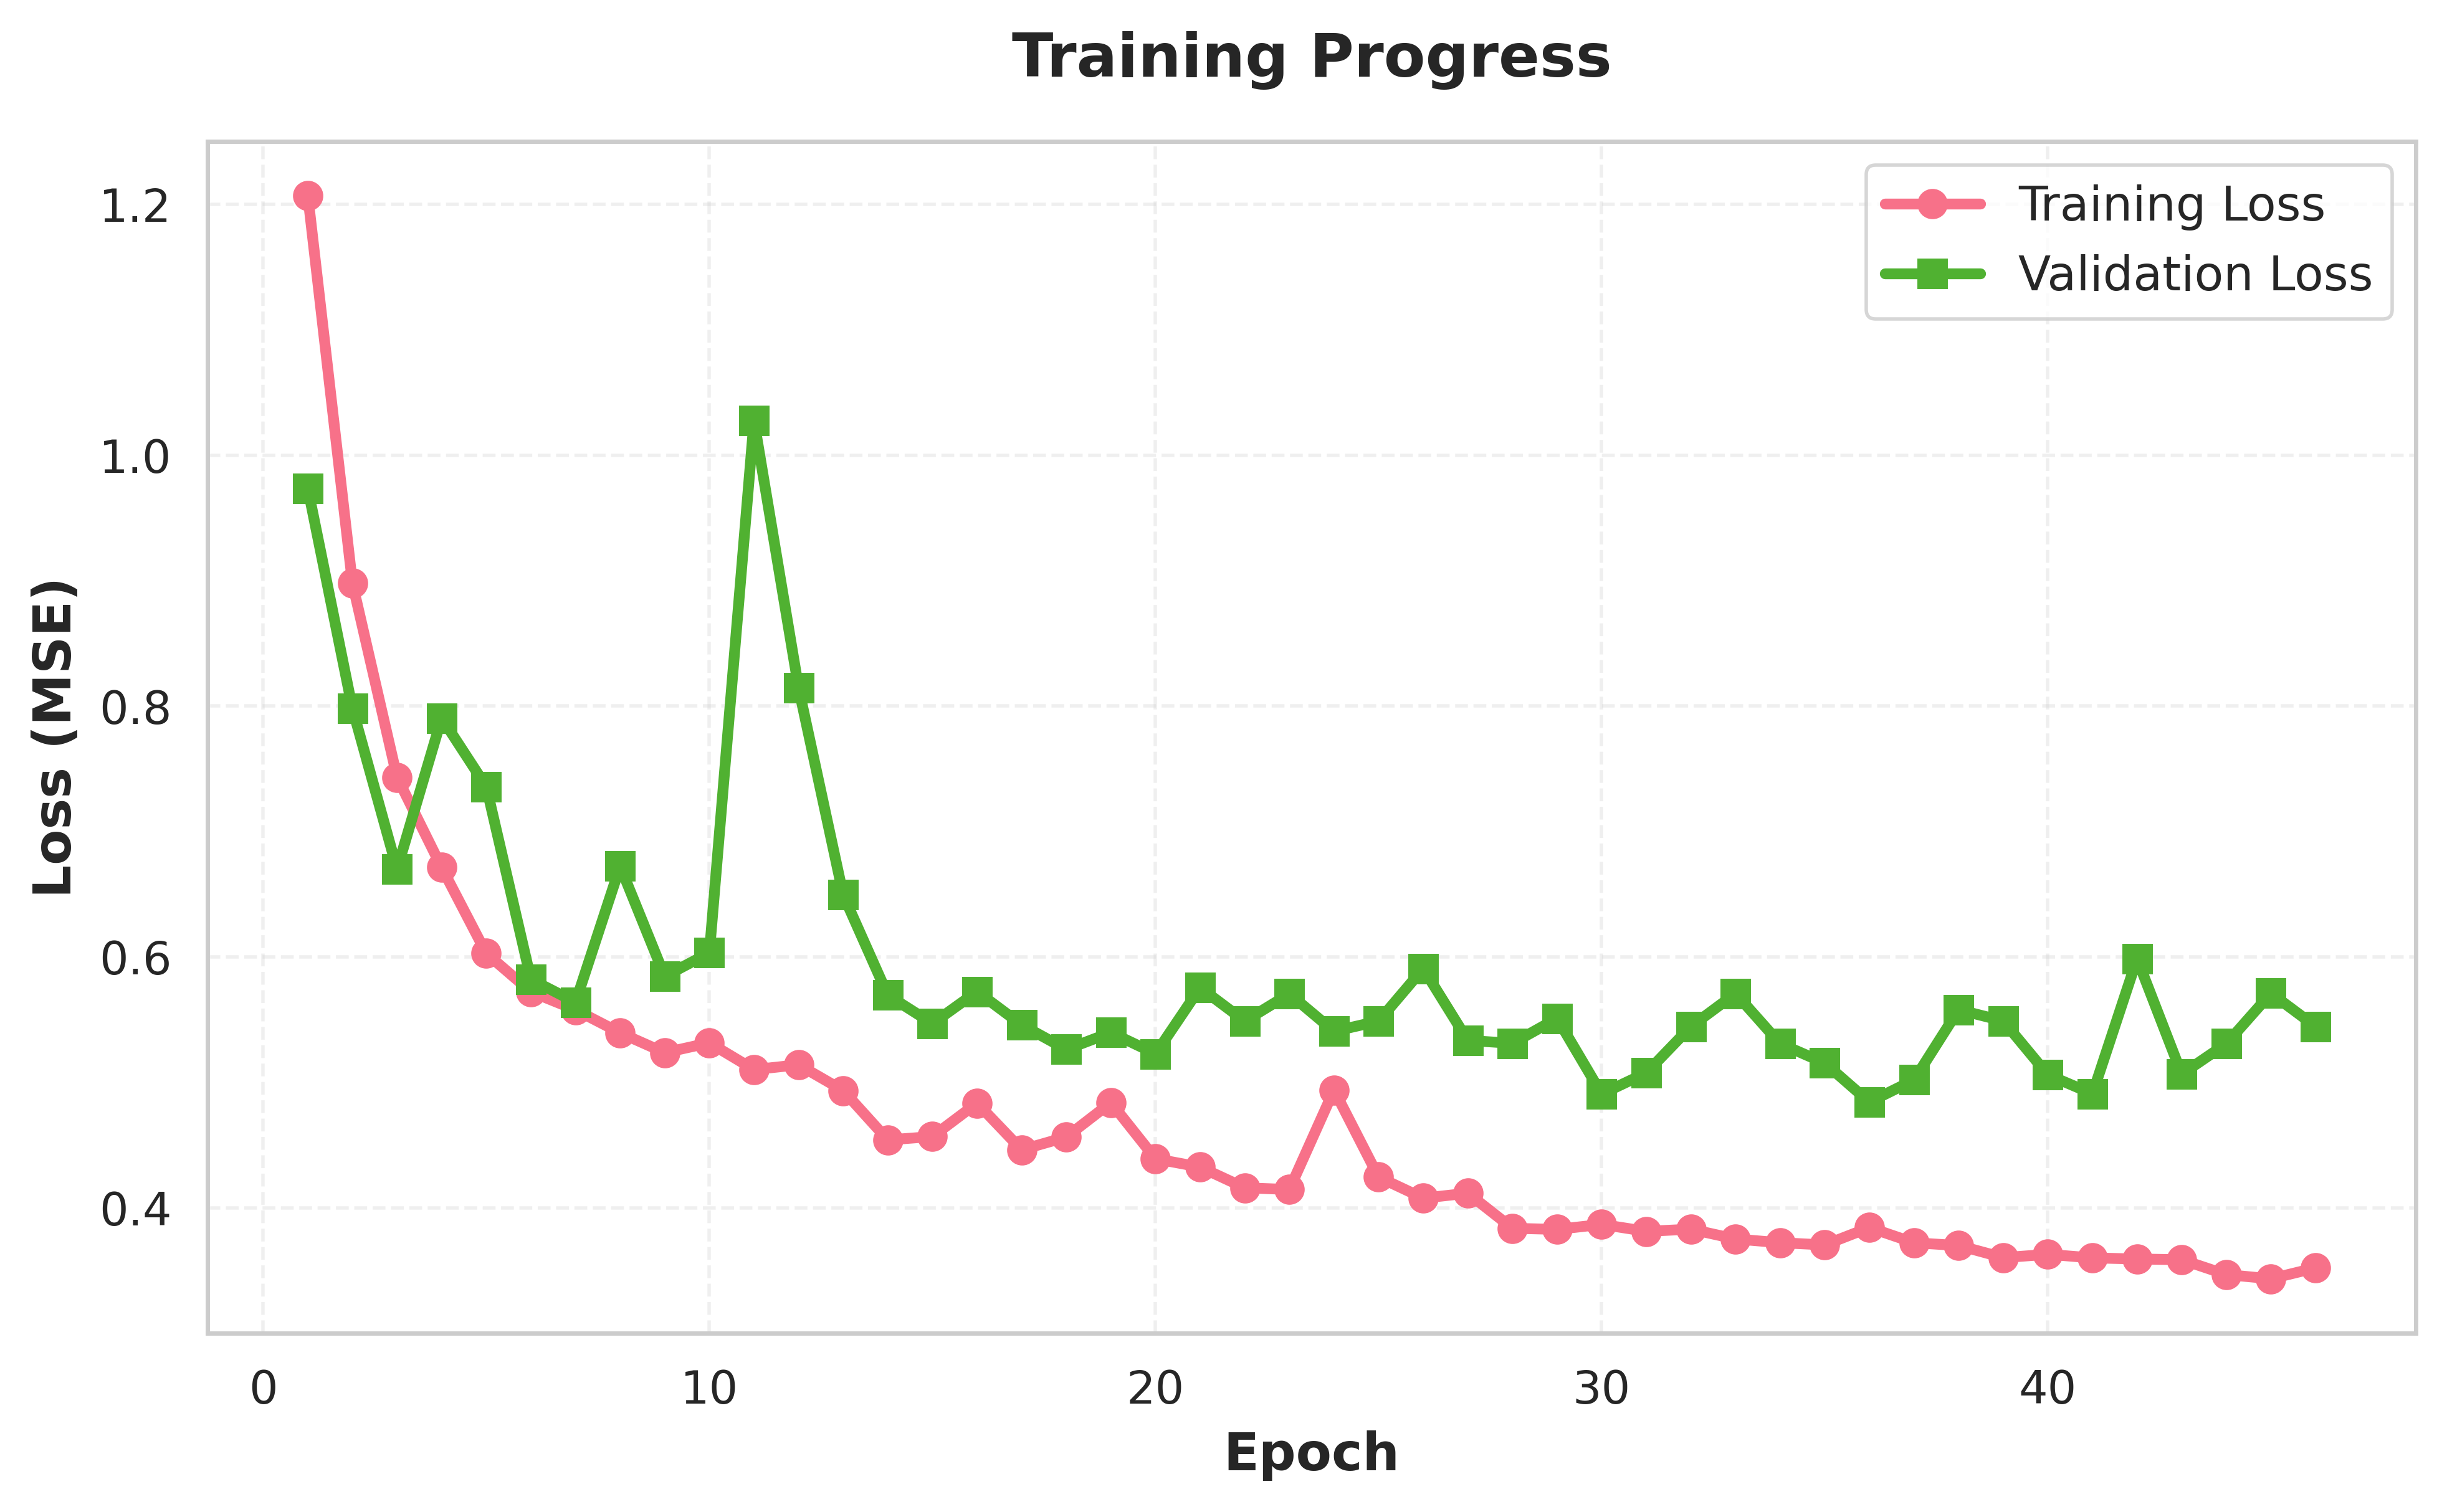

Saved: /content/drive/MyDrive/dont-thread-on-me/results/temporal_gnn/r2_over_time.png


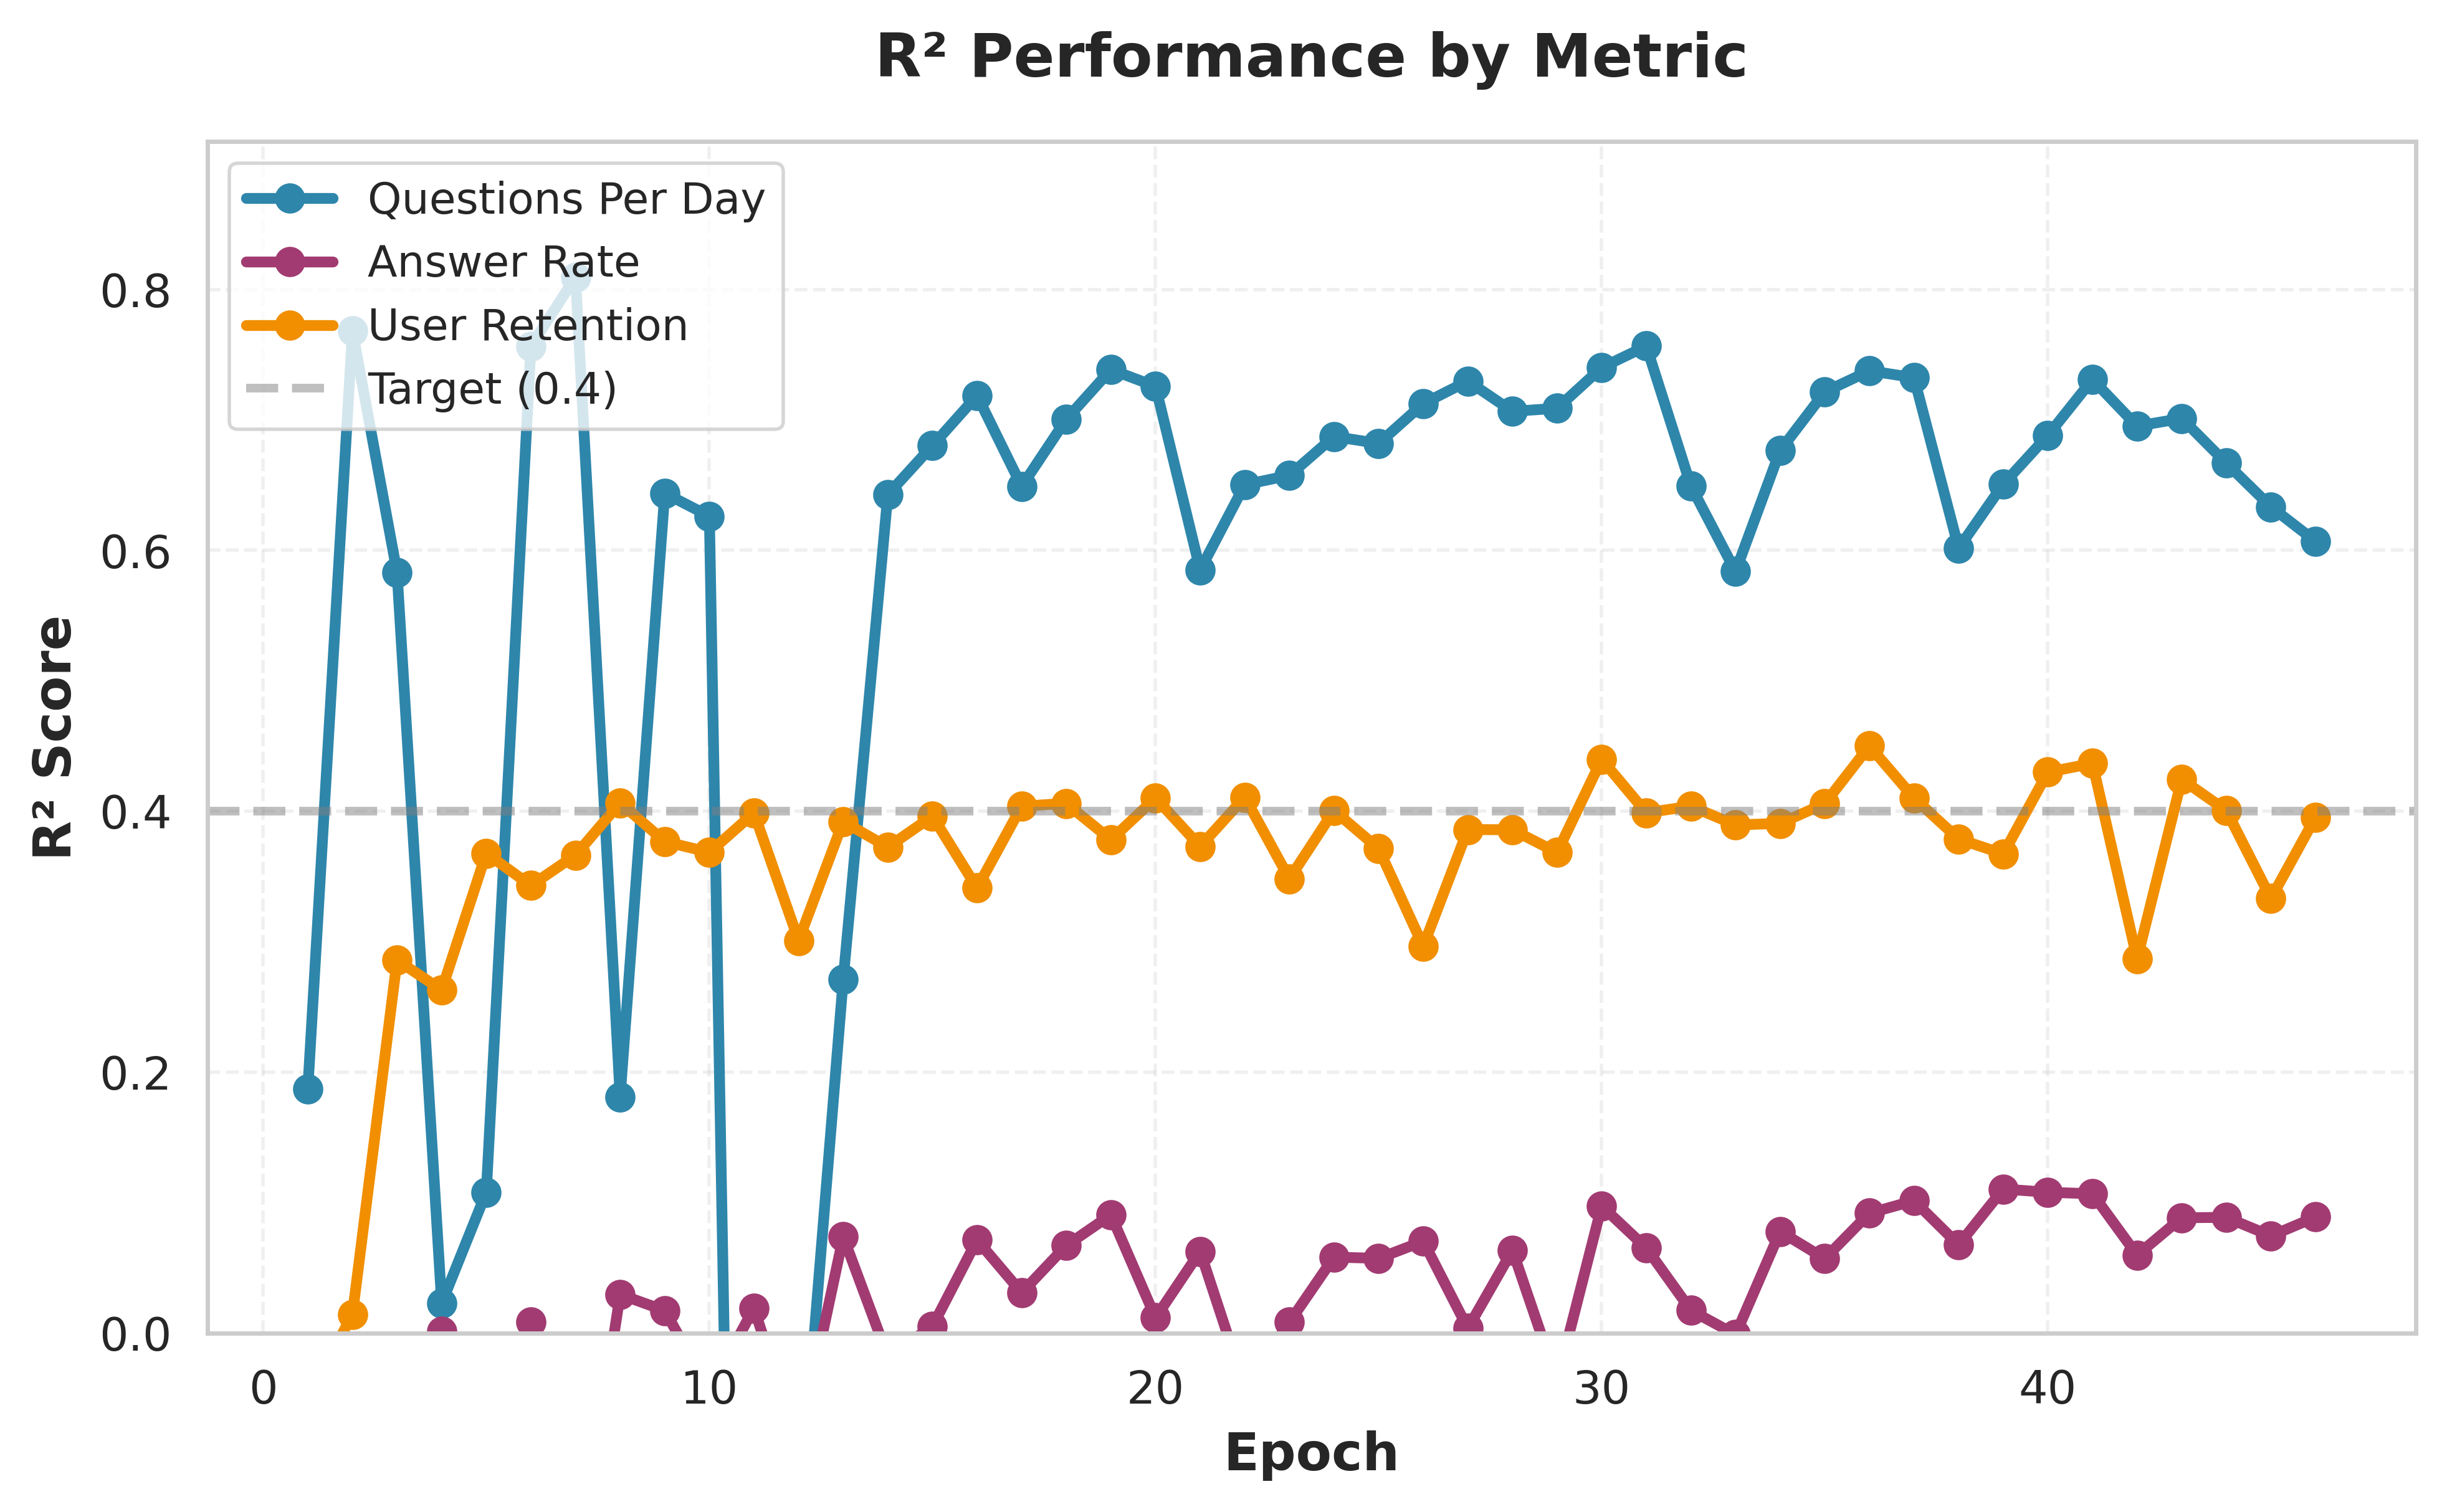

Saved: /content/drive/MyDrive/dont-thread-on-me/results/temporal_gnn/final_performance.png


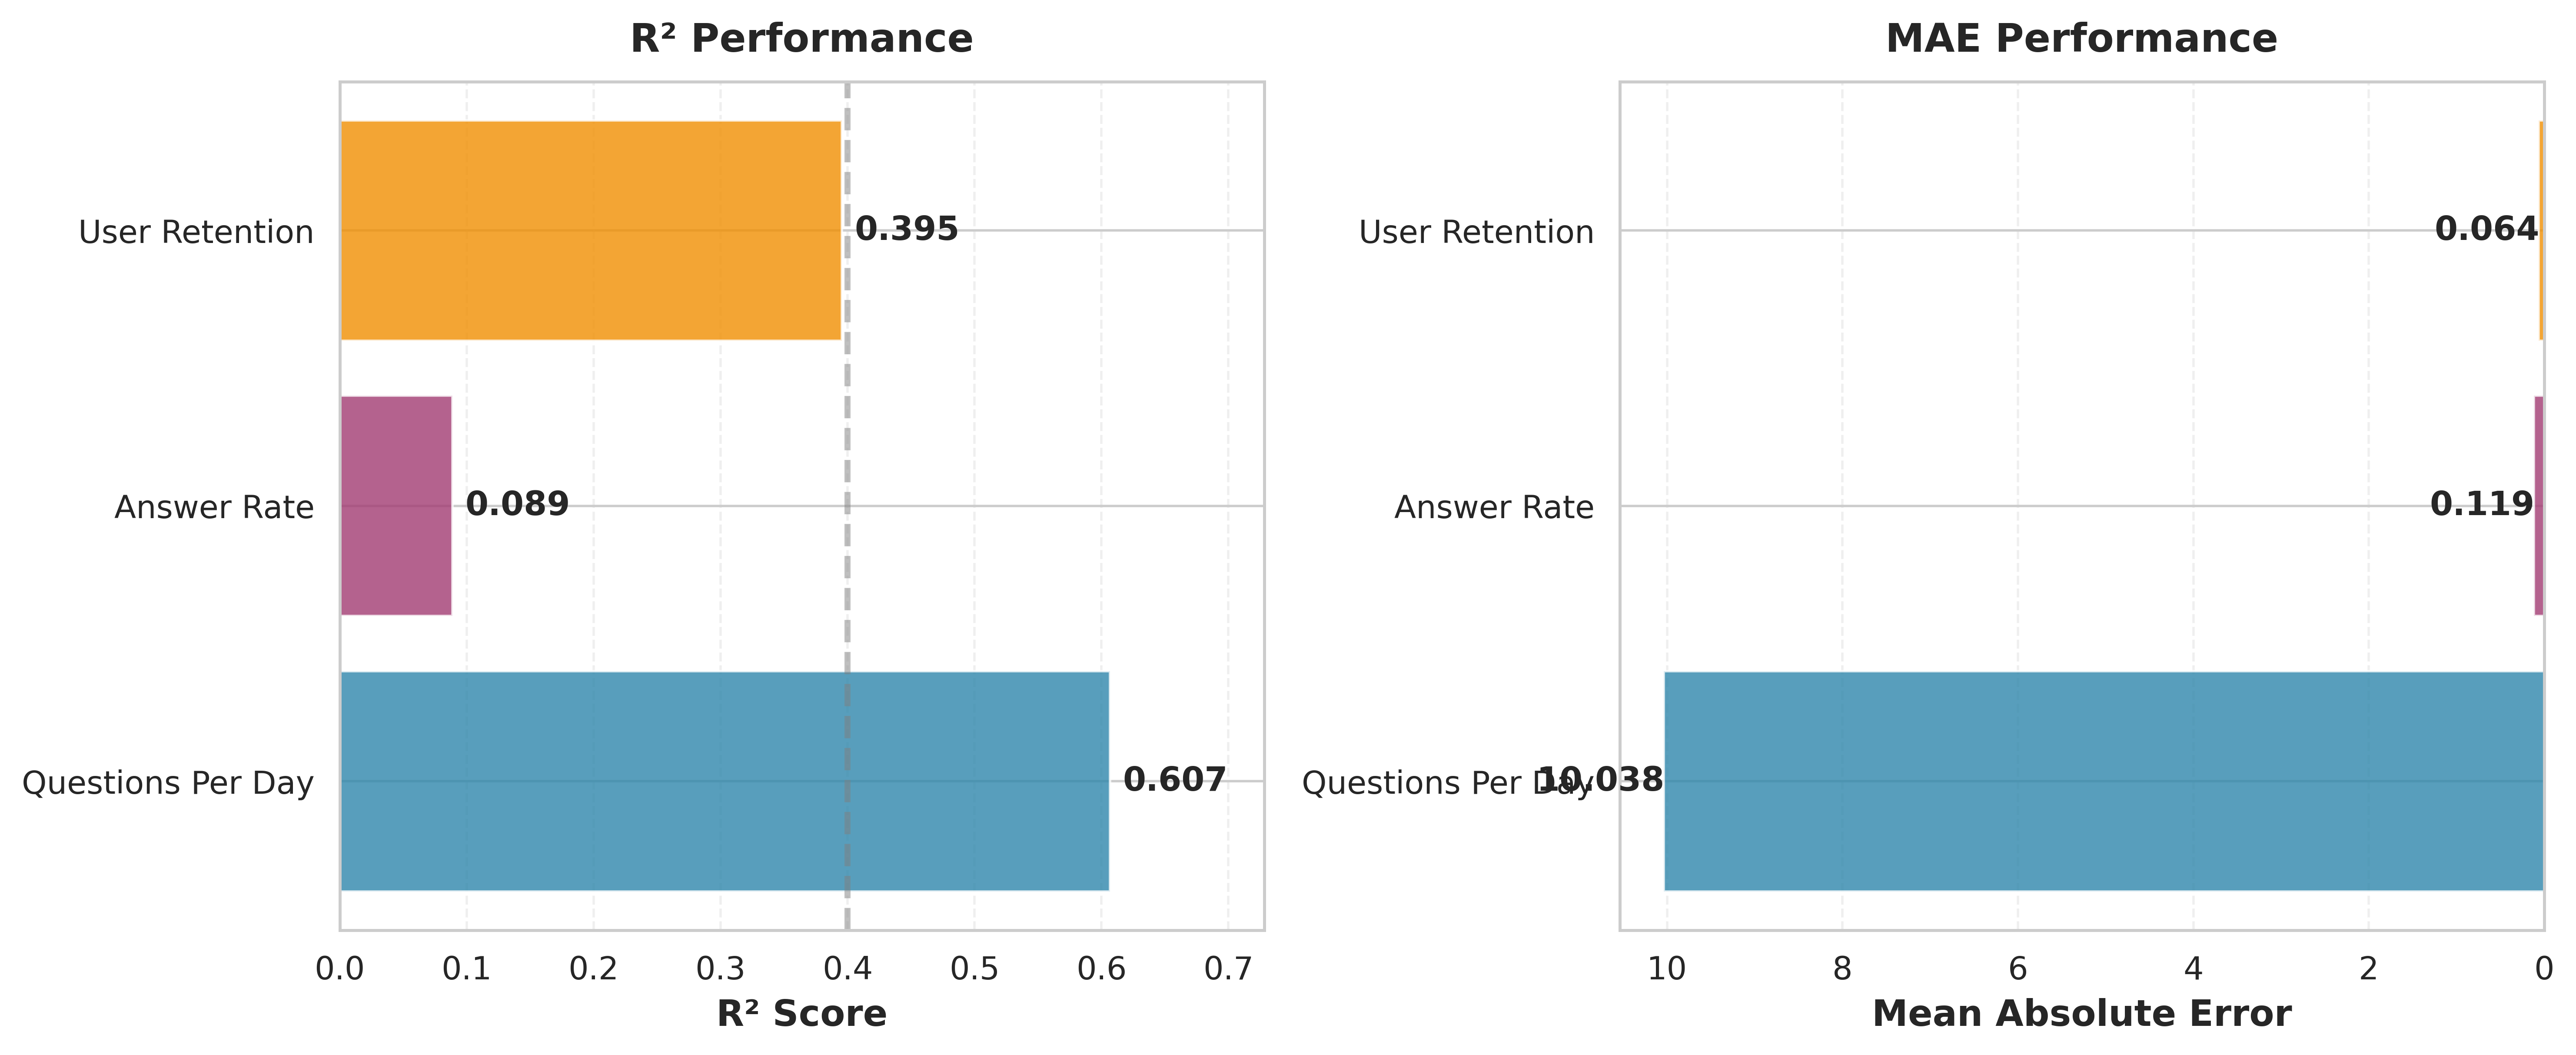

Saved: /content/drive/MyDrive/dont-thread-on-me/results/temporal_gnn/metric_evolution.png


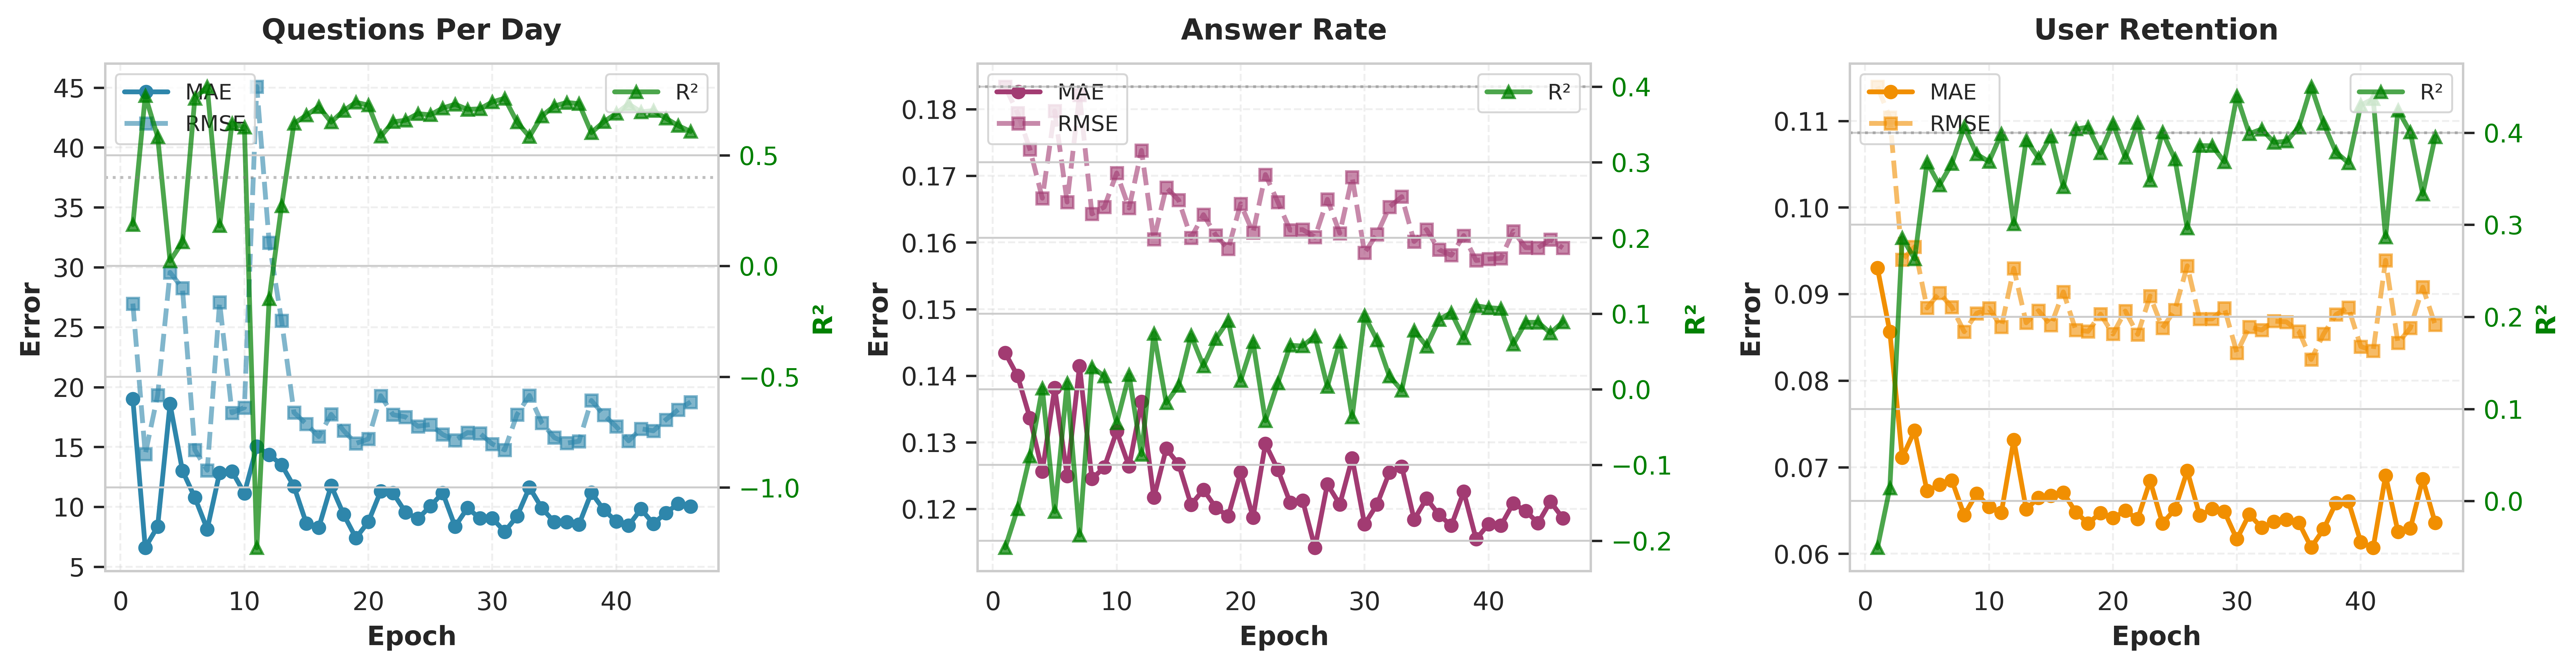

Saved: /content/drive/MyDrive/dont-thread-on-me/results/temporal_gnn/results_table.png


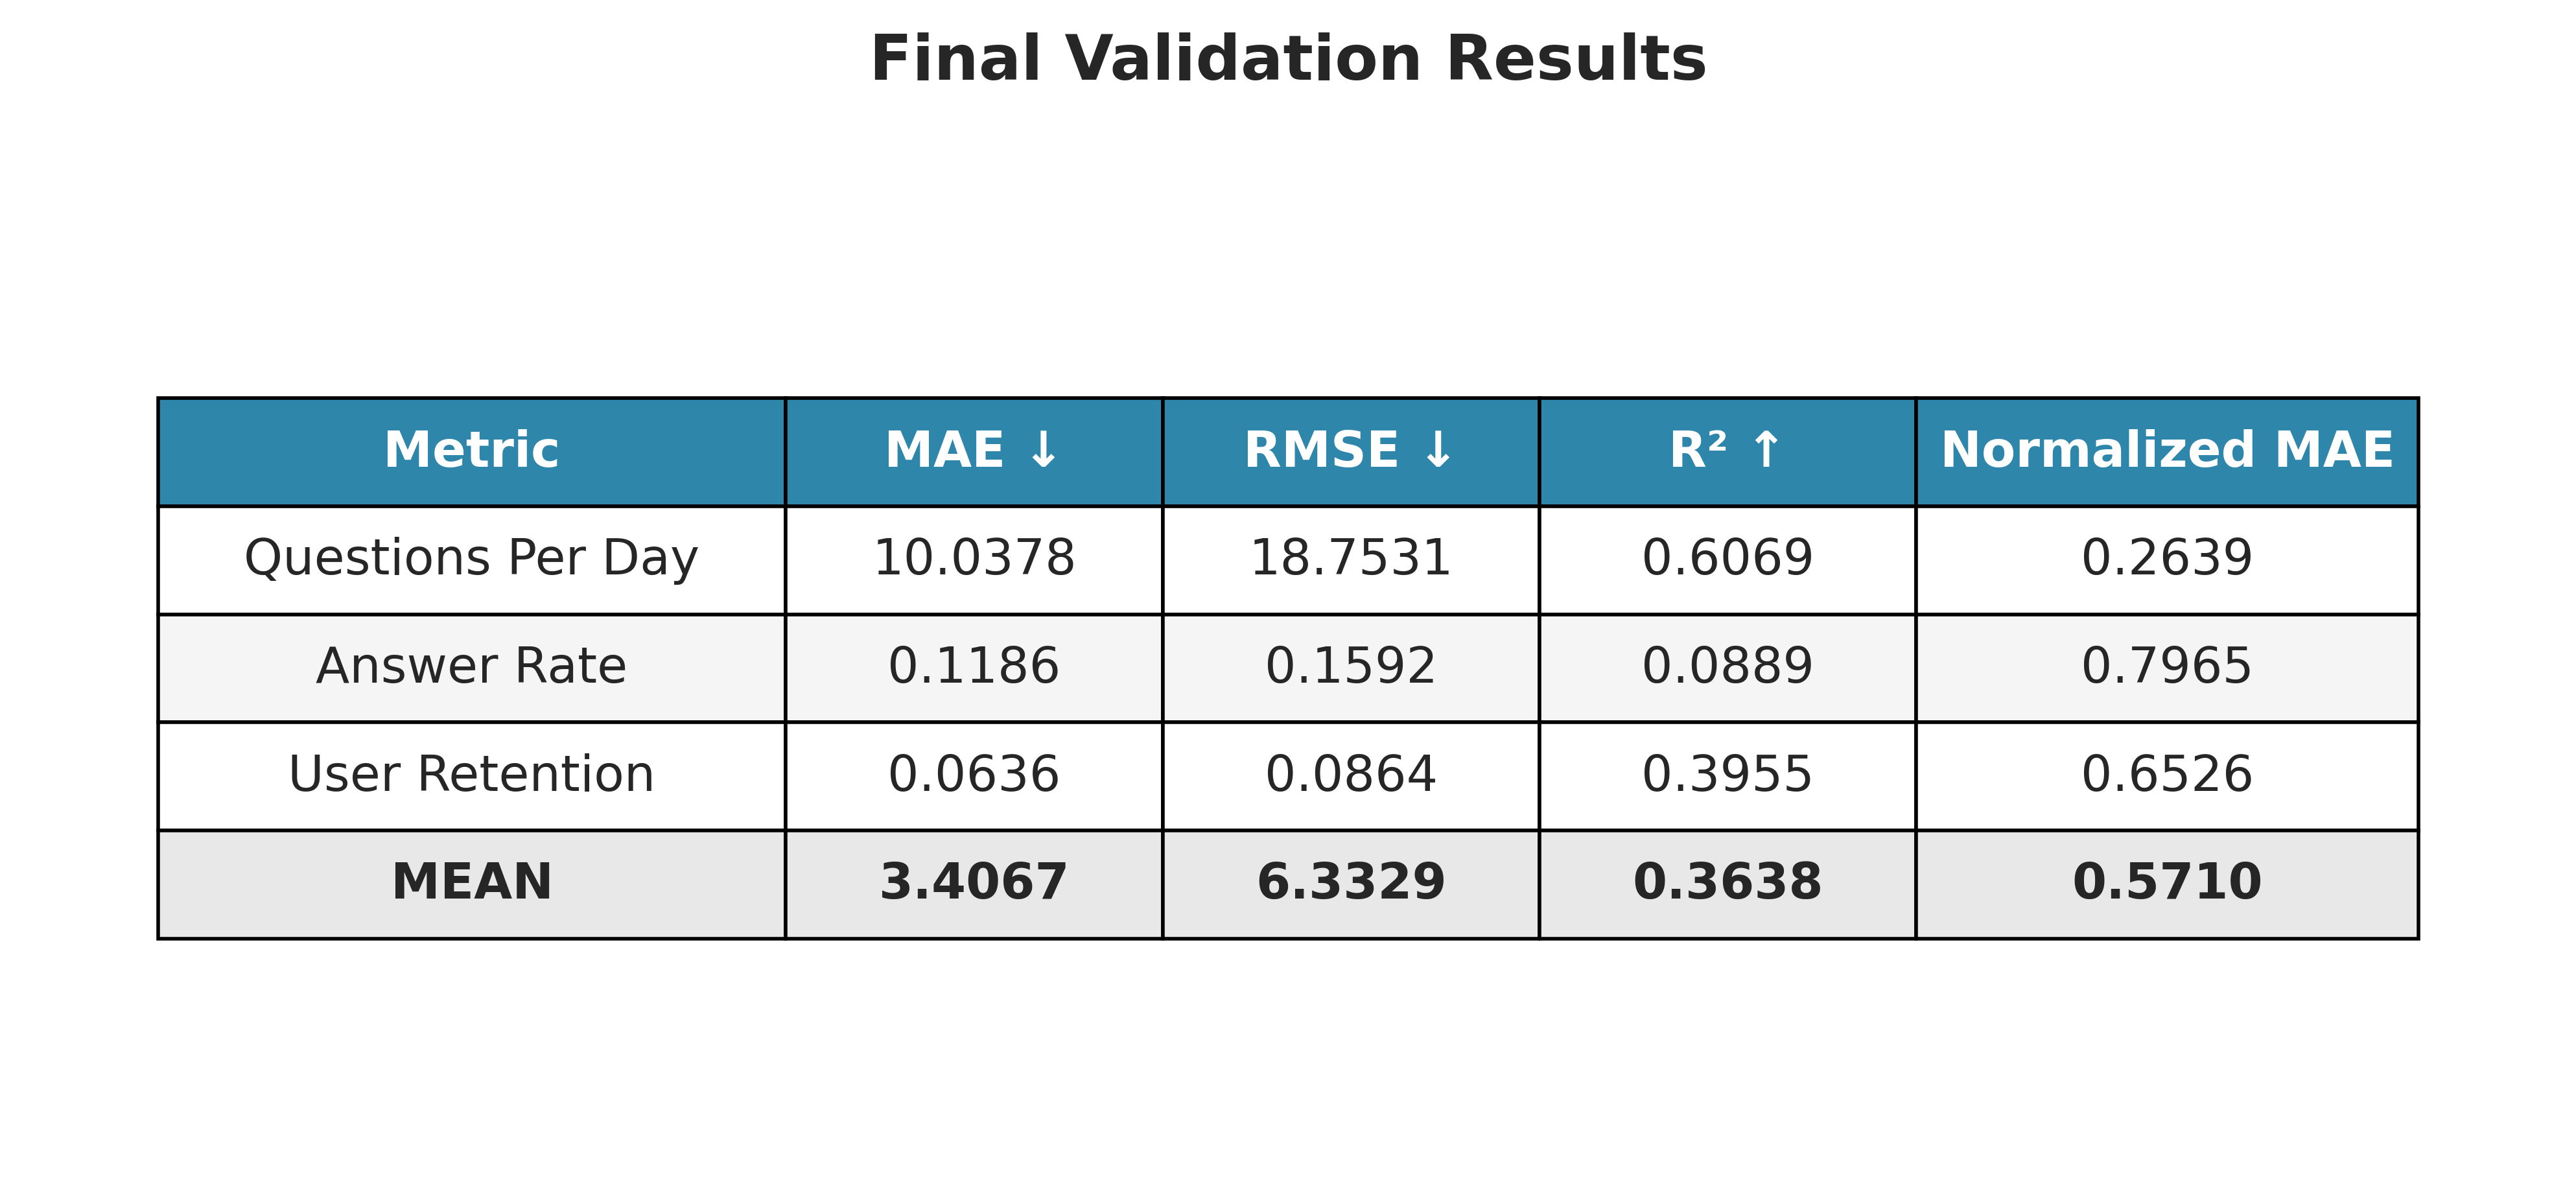


VISUALIZATION SUMMARY

All figures saved to: /content/drive/MyDrive/dont-thread-on-me/results/temporal_gnn/

Files created:
  1. loss_curves.png       - Training/validation loss
  2. r2_over_time.png      - R² evolution by metric
  3. final_performance.png - Final R² and MAE comparison
  4. metric_evolution.png  - Detailed metric tracking
  5. results_table.png     - Summary table


FINAL RESULTS SUMMARY

Best Validation Loss: 0.4843
Achieved at Epoch: N/A

Per-Metric Performance:
Metric               MAE ↓        RMSE ↓       R² ↑         Norm MAE ↓  
--------------------------------------------------------------------
Questions Per Day    10.0378      18.7531      0.6069       0.2639      
Answer Rate          0.1186       0.1592       0.0889       0.7965      
User Retention       0.0636       0.0864       0.3955       0.6526      
--------------------------------------------------------------------
MEAN                 3.4067       6.3329       0.3638       0.5710      

INTERPRET

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['font.family'] = 'sans-serif'

# Create results directory
results_dir = f"{PROJECT_DIR}/results/temporal_gnn" if IN_COLAB else "../results/temporal_gnn"
os.makedirs(results_dir, exist_ok=True)

# Color palette
colors = sns.color_palette("husl", 3)
metric_colors = {'qpd': '#2E86AB', 'answer_rate': '#A23B72', 'retention': '#F18F01'}

# ============================================================
# Figure 1: Training & Validation Loss
# ============================================================
fig, ax = plt.subplots(figsize=(8, 5))

epochs = np.arange(1, len(train_losses) + 1)
ax.plot(epochs, train_losses, marker='o', linewidth=2.5,
        label='Training Loss', color=colors[0], markersize=6)
ax.plot(epochs, val_losses, marker='s', linewidth=2.5,
        label='Validation Loss', color=colors[1], markersize=6)

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
ax.set_title('Training Progress', fontsize=14, fontweight='bold', pad=15)
ax.legend(frameon=True, loc='best', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f"{results_dir}/loss_curves.png", bbox_inches='tight')
print(f"Saved: {results_dir}/loss_curves.png")
plt.show()

# ============================================================
# Figure 2: R² Performance Over Time
# ============================================================
fig, ax = plt.subplots(figsize=(8, 5))

targets = ['qpd', 'answer_rate', 'retention']
labels = {'qpd': 'Questions Per Day', 'answer_rate': 'Answer Rate', 'retention': 'User Retention'}

for target in targets:
    r2_values = val_metrics_history[target]['r2']
    ax.plot(epochs, r2_values, marker='o', linewidth=2.5,
            label=labels[target], color=metric_colors[target], markersize=6)

ax.axhline(y=0.4, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Target (0.4)')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('R² Performance by Metric', fontsize=14, fontweight='bold', pad=15)
ax.legend(frameon=True, loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(f"{results_dir}/r2_over_time.png", bbox_inches='tight')
print(f"Saved: {results_dir}/r2_over_time.png")
plt.show()

# ============================================================
# Figure 3: Final Performance Comparison
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Prepare data
metric_names = [labels[t] for t in targets]
final_r2 = [val_metrics_history[t]['r2'][-1] for t in targets]
final_mae = [val_metrics_history[t]['mae'][-1] for t in targets]

# R² comparison
ax1 = axes[0]
bars = ax1.barh(metric_names, final_r2, color=[metric_colors[t] for t in targets], alpha=0.8)
ax1.axvline(x=0.4, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Target')
ax1.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Performance', fontsize=13, fontweight='bold', pad=10)
ax1.set_xlim(0, max(final_r2) * 1.2)
ax1.grid(True, alpha=0.3, linestyle='--', axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, final_r2)):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=11, fontweight='bold')

# MAE comparison
ax2 = axes[1]
bars = ax2.barh(metric_names, final_mae, color=[metric_colors[t] for t in targets], alpha=0.8)
ax2.set_xlabel('Mean Absolute Error', fontsize=12, fontweight='bold')
ax2.set_title('MAE Performance', fontsize=13, fontweight='bold', pad=10)
ax2.grid(True, alpha=0.3, linestyle='--', axis='x')
ax2.invert_xaxis()  # Lower is better

# Add value labels
for i, (bar, val) in enumerate(zip(bars, final_mae)):
    ax2.text(val - 0.01, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', ha='right', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{results_dir}/final_performance.png", bbox_inches='tight')
print(f"Saved: {results_dir}/final_performance.png")
plt.show()

# ============================================================
# Figure 4: Detailed Metric Evolution (3 subplots)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (target, ax) in enumerate(zip(targets, axes)):
    # Plot MAE and RMSE
    mae_values = val_metrics_history[target]['mae']
    rmse_values = val_metrics_history[target]['rmse']
    r2_values = val_metrics_history[target]['r2']

    color = metric_colors[target]

    # Primary axis: MAE and RMSE
    ax.plot(epochs, mae_values, marker='o', linewidth=2,
            label='MAE', color=color, markersize=5)
    ax.plot(epochs, rmse_values, marker='s', linewidth=2,
            label='RMSE', color=color, alpha=0.6, markersize=5, linestyle='--')

    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Error', fontsize=11, fontweight='bold')
    ax.set_title(labels[target], fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=9)

    # Secondary axis: R²
    ax2 = ax.twinx()
    ax2.plot(epochs, r2_values, marker='^', linewidth=2,
             label='R²', color='green', alpha=0.7, markersize=5)
    ax2.axhline(y=0.4, color='gray', linestyle=':', alpha=0.5)
    ax2.set_ylabel('R²', fontsize=11, fontweight='bold', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig(f"{results_dir}/metric_evolution.png", bbox_inches='tight')
print(f"Saved: {results_dir}/metric_evolution.png")
plt.show()

# ============================================================
# Figure 5: Results Summary Table (as image)
# ============================================================
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
table_data.append(['Metric', 'MAE ↓', 'RMSE ↓', 'R² ↑', 'Normalized MAE'])

norm_stats = train_dataset.norm_stats
for target in targets:
    final_mae = val_metrics_history[target]['mae'][-1]
    final_rmse = val_metrics_history[target]['rmse'][-1]
    final_r2 = val_metrics_history[target]['r2'][-1]
    norm_mae = final_mae / norm_stats[target]['std']

    table_data.append([
        labels[target],
        f'{final_mae:.4f}',
        f'{final_rmse:.4f}',
        f'{final_r2:.4f}',
        f'{norm_mae:.4f}'
    ])

# Add mean row
mean_mae = np.mean([val_metrics_history[t]['mae'][-1] for t in targets])
mean_rmse = np.mean([val_metrics_history[t]['rmse'][-1] for t in targets])
mean_r2 = np.mean([val_metrics_history[t]['r2'][-1] for t in targets])
mean_norm_mae = np.mean([val_metrics_history[t]['mae'][-1] / norm_stats[t]['std'] for t in targets])

table_data.append([
    'MEAN',
    f'{mean_mae:.4f}',
    f'{mean_rmse:.4f}',
    f'{mean_r2:.4f}',
    f'{mean_norm_mae:.4f}'
])

# Create table
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.25, 0.15, 0.15, 0.15, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header row
for i in range(5):
    cell = table[(0, i)]
    cell.set_facecolor('#2E86AB')
    cell.set_text_props(weight='bold', color='white')

# Style mean row
for i in range(5):
    cell = table[(len(table_data)-1, i)]
    cell.set_facecolor('#E8E8E8')
    cell.set_text_props(weight='bold')

# Alternate row colors
for i in range(1, len(table_data)-1):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#F5F5F5')

plt.title('Final Validation Results', fontsize=14, fontweight='bold', pad=20)
plt.savefig(f"{results_dir}/results_table.png", bbox_inches='tight')
print(f"Saved: {results_dir}/results_table.png")
plt.show()

# ============================================================
# Print Summary
# ============================================================
print("\n" + "="*70)
print("VISUALIZATION SUMMARY")
print("="*70)
print(f"\nAll figures saved to: {results_dir}/")
print("\nFiles created:")
print("  1. loss_curves.png       - Training/validation loss")
print("  2. r2_over_time.png      - R² evolution by metric")
print("  3. final_performance.png - Final R² and MAE comparison")
print("  4. metric_evolution.png  - Detailed metric tracking")
print("  5. results_table.png     - Summary table")
print("\n" + "="*70)

# ============================================================
# Detailed Text Summary
# ============================================================
print("\nFINAL RESULTS SUMMARY")
print("="*70)
print(f"\nBest Validation Loss: {best_val_loss:.4f}")
print(f"Achieved at Epoch: {checkpoint['epoch'] if 'checkpoint' in globals() else 'N/A'}\n")

print("Per-Metric Performance:")
print(f"{'Metric':<20} {'MAE ↓':<12} {'RMSE ↓':<12} {'R² ↑':<12} {'Norm MAE ↓':<12}")
print("-" * 68)

for target in targets:
    final_mae = val_metrics_history[target]['mae'][-1]
    final_rmse = val_metrics_history[target]['rmse'][-1]
    final_r2 = val_metrics_history[target]['r2'][-1]
    norm_mae = final_mae / norm_stats[target]['std']

    print(f"{labels[target]:<20} {final_mae:<12.4f} {final_rmse:<12.4f} "
          f"{final_r2:<12.4f} {norm_mae:<12.4f}")

print("-" * 68)
print(f"{'MEAN':<20} {mean_mae:<12.4f} {mean_rmse:<12.4f} "
      f"{mean_r2:<12.4f} {mean_norm_mae:<12.4f}")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)

if mean_r2 > 0.5:
    print("✓ Strong predictive performance (R² > 0.5)")
elif mean_r2 > 0.4:
    print("✓ Good predictive performance (R² > 0.4)")
elif mean_r2 > 0.3:
    print("⚠ Moderate performance (R² > 0.3)")
    print("  Consider: Temporal distribution shift (COVID-19 period in validation)")
else:
    print("⚠ Weak performance (R² < 0.3)")

print("\nPractical Interpretation:")
print(f"  • Questions/Day:  ±{val_metrics_history['qpd']['mae'][-1]:.2f} questions")
print(f"  • Answer Rate:    ±{val_metrics_history['answer_rate']['mae'][-1]:.1%}")
print(f"  • User Retention: ±{val_metrics_history['retention']['mae'][-1]:.1%}")

print("\nNormalized MAE (lower is better):")
for target in targets:
    norm_mae = val_metrics_history[target]['mae'][-1] / norm_stats[target]['std']
    if norm_mae < 0.5:
        status = "✓ Excellent"
    elif norm_mae < 1.0:
        status = "✓ Good"
    else:
        status = "⚠ Needs improvement"
    print(f"  • {labels[target]:<17}: {norm_mae:.3f} {status}")

print("\n" + "="*70)

## 10. Save GNN Results

In [ ]:
# Save GNN results
gnn_results = {
    'val_loss': best_val_loss,
    'metrics': metrics,  # Final validation metrics
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_metrics_history': val_metrics_history
}

with open(f"{results_dir}/gnn_results.pkl", 'wb') as f:
    pickle.dump(gnn_results, f)